In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import uproot3 as uproot
import os

mpl.rcParams['figure.dpi'] = 200
from scipy.optimize import curve_fit
import scipy.stats as stats


import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


%matplotlib inline

/scratch/lng/ipykernel_1600376/1047005176.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def loadDF(fileName,treeName,cols):
    ''' Function to load a root file '''
    tree=uproot.open(fileName)[treeName]
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    return df

def f(x,a,b,c,d):
    return a*np.arctan(b*x+c)+d

# Refined Analysis - v1 #

In [3]:
baseFolder="/d/grid17/ln16/dselector_v3/phase1_selected_v2/"
ofolder='results'
if os.path.exists(ofolder):
    os.system(f"rm -r {ofolder}")
os.system(f"mkdir {ofolder}")

ftype='png'

In [5]:
columns=[
    "Mpi0eta", "Ebeam","mandelstam_t","mandelstam_teta","mandelstam_tpi0",
    "cosTheta_eta_gj", "phi_eta_gj", "cosTheta_eta_hel", "phi_eta_hel", "vanHove_omega", "vanHove_x", "vanHove_y",
    "Mpi0p","Metap","pVH_pi0p","pVH_etap","cosTheta_eta_cm","cosTheta_pi0_cm",
    "AccWeight","weightBS","weightASBS"
]

runs=["2017_1","2018_1","2018_8"]
data_tmp=[]
acc_tmp=[]
for run in runs:
    data_tmp.append(loadDF(baseFolder+"D"+run+"_selected_acc_flat.root","kin",cols=columns))
    acc_tmp.append(loadDF(baseFolder+"F"+run+"_selected_acc_flat.root","kin",cols=columns))
    
data_tmp=pd.concat(data_tmp)
acc_tmp=pd.concat(acc_tmp)

In [6]:
data_tmp=data_tmp.reset_index(drop=True)
acc_tmp=acc_tmp.reset_index(drop=True)

In [7]:
min_mpi0eta=1.04
max_mpi0eta=1.80

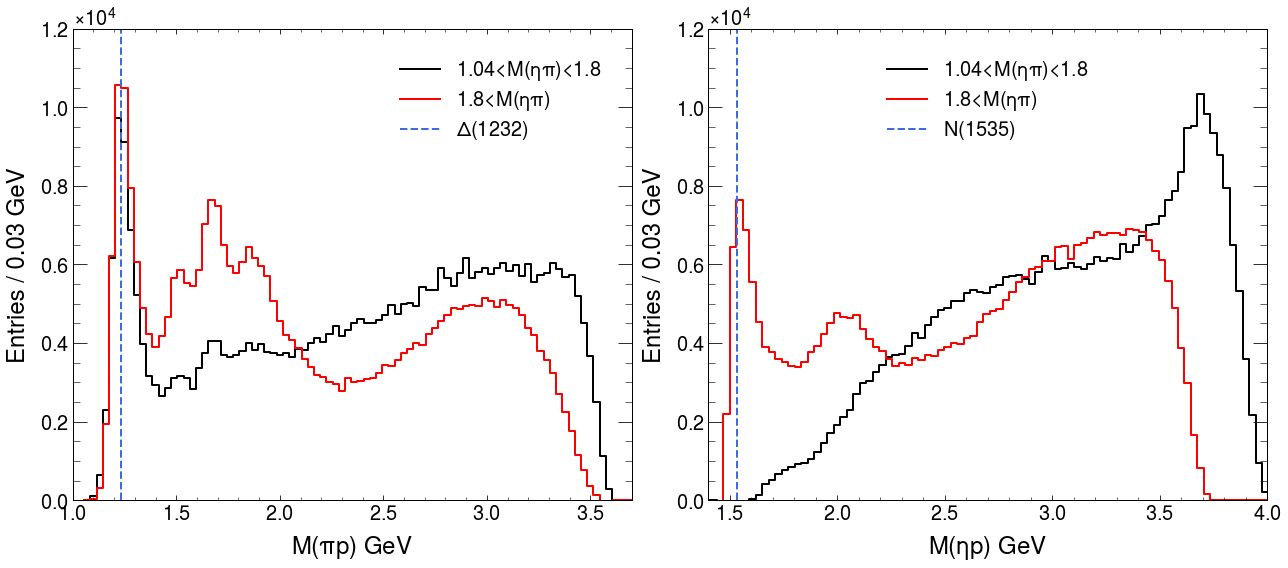

In [8]:
fig,axes=plt.subplots(1,2,figsize=(18,8))

for ax, var, varPretty, known_resonances, resonance_label, axlim in zip(axes,["Mpi0p","Metap"],[r"$M(\pi p)$",r"$M(\eta p)$"],
                                                                 [[1.232],[1.535]],[[r"$\Delta(1232)$"],[r"$N(1535)$"]],
                                                                [[1.0, 3.7],[1.40,4.0]]):
    edges=np.linspace(data_tmp[var].min(),data_tmp[var].max(),90)
    width=edges[1]-edges[0]
    tmp=data_tmp[(data_tmp.Mpi0eta>min_mpi0eta)&(data_tmp.Mpi0eta<max_mpi0eta)]
    hep.histplot(np.histogram(tmp[var],weights=tmp.weightASBS,bins=edges),label=f"{min_mpi0eta}<$M(\eta\pi)$<{max_mpi0eta}",c='black',ax=ax)
    tmp=data_tmp[(data_tmp.Mpi0eta>max_mpi0eta)]
    hep.histplot(np.histogram(tmp[var],weights=tmp.weightASBS,bins=edges),label=f"{max_mpi0eta}<$M(\eta\pi)$",c='red',ax=ax)
    ax.set_ylim(0)
    ax.set_ylim(0)
    ax.set_xlim(*axlim)
    ax.set_xlabel(varPretty+" GeV",size=24)
    [ax.axvline(v,c='royalblue',linestyle='--',label=l) for v,l in zip(known_resonances,resonance_label)]
    ax.legend(prop={"size":20})
    ax.set_ylabel(f"Entries / {width:0.02f} GeV",size=24)

plt.tight_layout()
# plt.savefig(f'{ofolder}/baryons_in_massRegion.{ftype}')

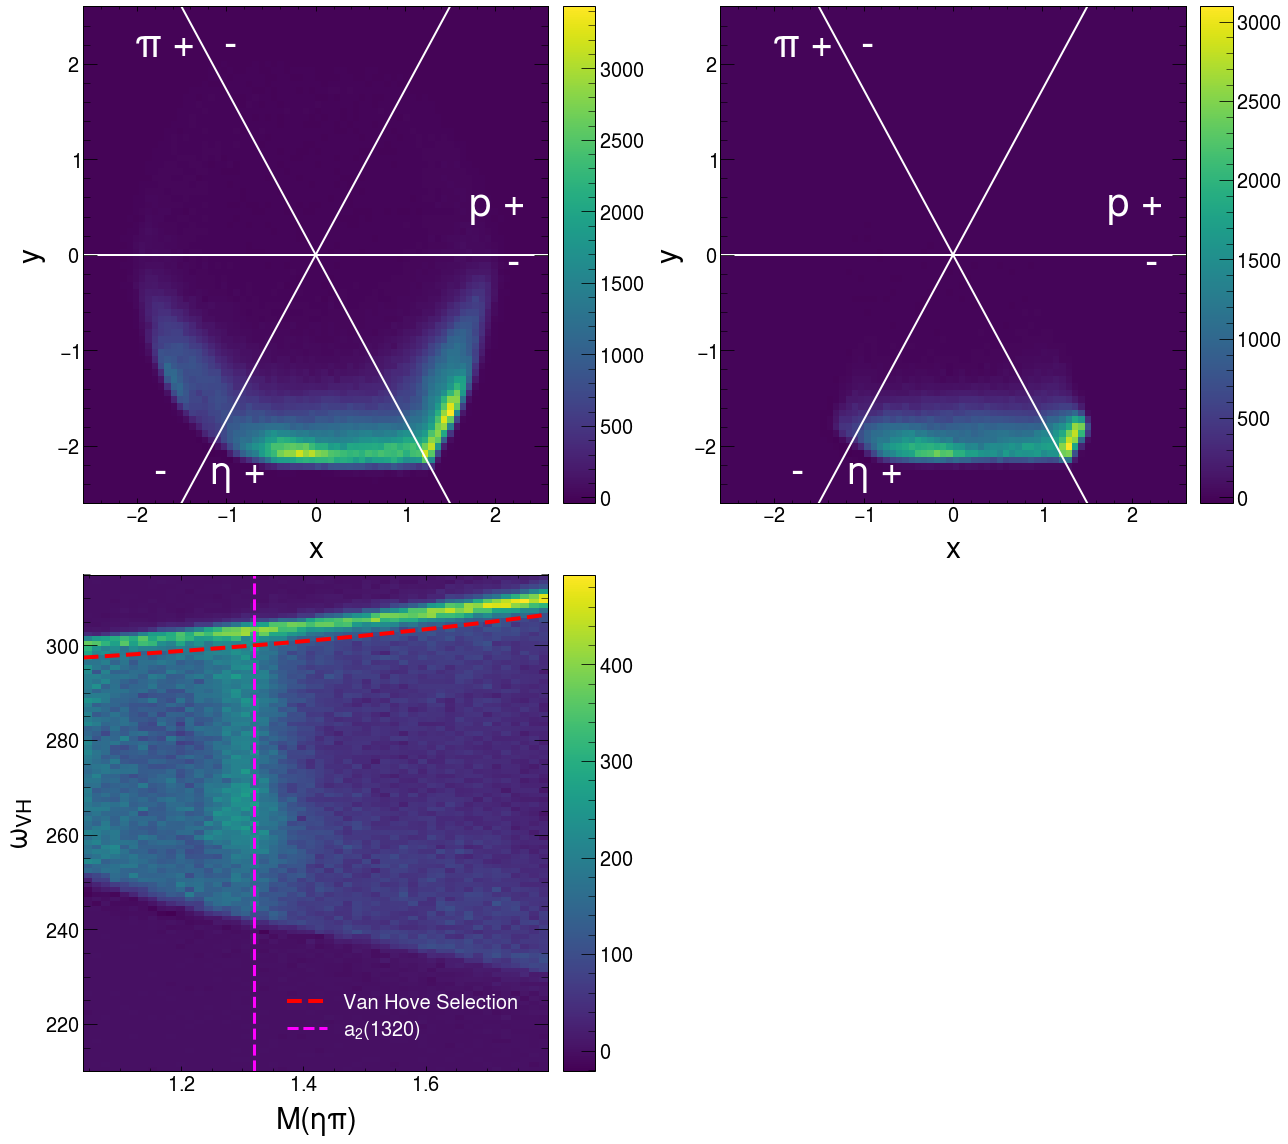

In [59]:
xs=np.linspace(data_tmp.Mpi0eta.min(),data_tmp.Mpi0eta.max(),200)

ys=f(xs,-29.61317407,-0.9877663,2.77936736,330.46008765) # old 

args2=(-29.5,-1.05,2.78,328) # new
ys2=f(xs,*args2)

data_tmp["pVH"]=f(data_tmp["Mpi0eta"],*args2) > data_tmp.vanHove_omega
tmp=data_tmp[
    (data_tmp.vanHove_omega>160)
    &(data_tmp.Mpi0eta>min_mpi0eta)&(data_tmp.Mpi0eta<max_mpi0eta)
]

fig,axes=plt.subplots(2,2,figsize=(18,16))
axes=axes.flatten()

edges=(np.linspace(-2.6,2.6,75),np.linspace(-2.6,2.6,75))
for ax, df in zip(axes,[data_tmp,tmp]):
    hep.hist2dplot(np.histogram2d(x=df.vanHove_x,y=df.vanHove_y,weights=df.weightASBS,bins=edges),ax=ax)
    ax.set_xlabel("x",size=30)
    ax.set_ylabel("y",size=30)
    ax.plot([-2,2],[-2*np.sqrt(3),2*np.sqrt(3)],c='white')
    ax.plot([-5,5],[0,0],c='white')
    ax.plot([-2,2],[2*np.sqrt(3),-2*np.sqrt(3)],c='white')
    ax.text(0.15,0.04,"-",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)
    ax.text(0.27,0.04,"$\eta$ +",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)
    ax.text(0.83,0.58,"p +",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)
    ax.text(0.91,0.46,"-",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)
    ax.text(0.11,0.90,r"$\pi$ +",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)
    ax.text(0.30,0.90,"-",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)


hep.hist2dplot(np.histogram2d(tmp.Mpi0eta,tmp.vanHove_omega,weights=tmp.weightASBS,bins=(50,200)),ax=axes[2])
plt.plot(xs,ys2,c='red',linestyle='--',linewidth=4,label="Van Hove Selection")
axes[2].set_ylim(210,315)
[axes[2].axvline(v,c='magenta',linestyle='--',linewidth=3,label=k) for k,v in zip([r"$a_2(1320)$"],[1.320])]
axes[2].set_xlabel(r"$M(\eta\pi)$",size=30)
axes[2].set_ylabel(r"$\omega_{VH}$",size=30)
l=axes[2].legend(loc=4,prop={'size':20})
for text in l.get_texts():
    text.set_color("white")
    
axes[3].axis(False)
    
plt.tight_layout()
plt.savefig(f'{ofolder}/vanhove_selection.{ftype}')

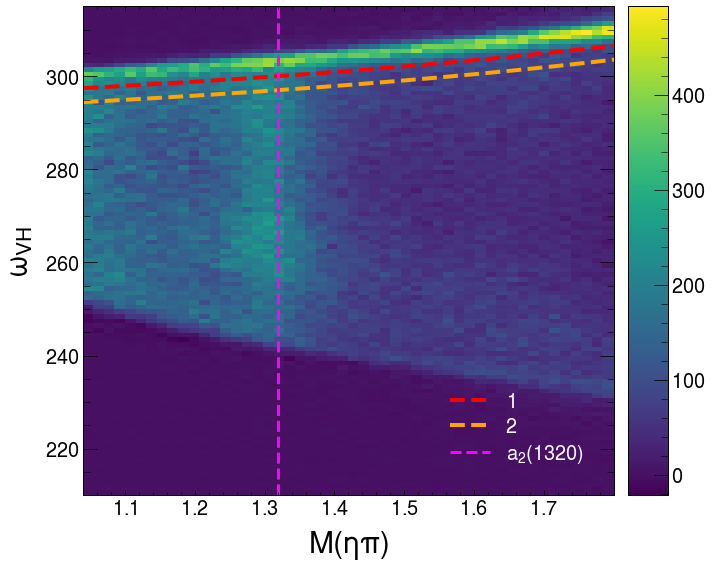

In [80]:
fig,axes=plt.subplots(figsize=(10,8))

data_tmp["pVH"]=f(data_tmp["Mpi0eta"],*args2) > data_tmp.vanHove_omega
tmp=data_tmp[
    (data_tmp.vanHove_omega>160)
    &(data_tmp.Mpi0eta>min_mpi0eta)&(data_tmp.Mpi0eta<max_mpi0eta)
]

hep.hist2dplot(np.histogram2d(tmp.Mpi0eta,tmp.vanHove_omega,weights=tmp.weightASBS,bins=(50,200)),ax=axes)

ys=f(xs,*(-29.5,-1.05,2.78,328))
plt.plot(xs,ys,c='red',linestyle='--',linewidth=4,label="1")
ys=f(xs,*(-29.5,-1.05,2.78,325))
plt.plot(xs,ys,c='orange',linestyle='--',linewidth=4,label='2')

axes.set_ylim(210,315)
[axes.axvline(v,c='magenta',linestyle='--',linewidth=3,label=k) for k,v in zip([r"$a_2(1320)$"],[1.320])]
axes.set_xlabel(r"$M(\eta\pi)$",size=30)
axes.set_ylabel(r"$\omega_{VH}$",size=30)
l=axes.legend(loc=4,prop={'size':20})
for text in l.get_texts():
    text.set_color("white")
    
plt.tight_layout()

/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


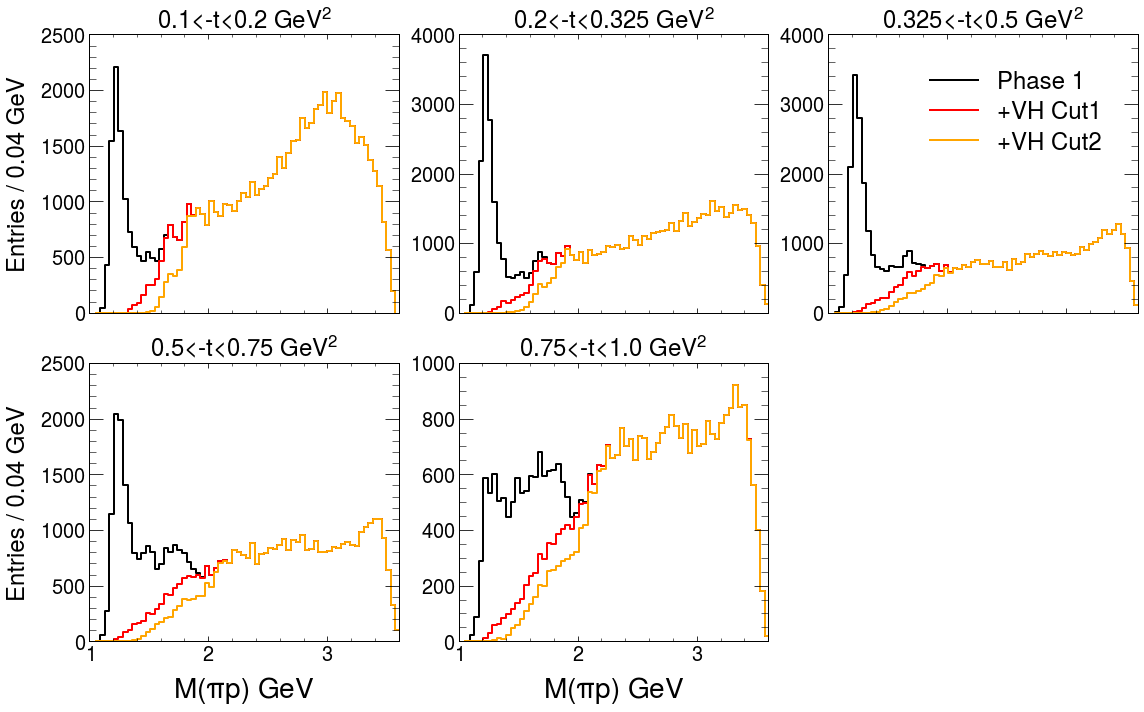

In [81]:
test_ts=[0.1,0.2,0.325,0.5,0.75,1.0]

fig,axes=plt.subplots(2,3,figsize=(16,10),sharex=True)
axes=axes.flatten()

edges=np.histogram(data_tmp.Mpi0p,bins=70)[1]
width=edges[1]-edges[0]
for i in range(len(test_ts)-1):
    test_mint=test_ts[i]
    test_maxt=test_ts[i+1]
    axes[i].set_title(f"{test_mint}<-t<{test_maxt} $GeV^2$",size=24)
    tmp=data_tmp[
        (data_tmp.mandelstam_t>test_mint)&(data_tmp.mandelstam_t<test_maxt)
        &(data_tmp.Mpi0eta>min_mpi0eta)&(data_tmp.Mpi0eta<max_mpi0eta)
    ]
    hep.histplot(np.histogram(tmp.Mpi0p,weights=tmp.weightASBS,bins=edges),ax=axes[i],c='black',label="Phase 1")
    
    args2=(-29.5,-1.05,2.78,328) # new
    tmp["pVH"]=f(tmp["Mpi0eta"],*args2) > tmp.vanHove_omega
    hep.histplot(np.histogram(tmp.loc[tmp.pVH,'Mpi0p'],weights=tmp.loc[tmp.pVH,'weightASBS'],bins=edges),ax=axes[i],c='red',label="+VH Cut1")
    
    args2=(-29.5,-1.05,2.78,325) # new
    tmp["pVH"]=f(tmp["Mpi0eta"],*args2) > tmp.vanHove_omega
    hep.histplot(np.histogram(tmp.loc[tmp.pVH,'Mpi0p'],weights=tmp.loc[tmp.pVH,'weightASBS'],bins=edges),ax=axes[i],c='orange',label="+VH Cut2")
    
    axes[i].set_ylim(0)
    axes[i].set_xlim(1.0,3.6)
    
axes[2].legend(prop={"size":24})

# tmp=data_tmp[(data_tmp.mandelstam_t>0.1)&(data_tmp.mandelstam_t<1.0)]
# hep.histplot(np.histogram(tmp.Mpi0p,weights=tmp.weightASBS,bins=edges),ax=axes[5],c='black',label="phase1")
# tmp=tmp[tmp.pVH]
# hep.histplot(np.histogram(tmp.Mpi0p,weights=tmp.weightASBS,bins=edges),ax=axes[5],c='red',label="+VH Cut")
# axes[5].legend(prop={"size":20})
# axes[5].set_ylim(0)
# axes[5].set_xlim(1.0,3.6)
# axes[5].set_title("0.1<-t<1.0 $GeV^2$",size=24)
axes[5].axis(False)

[axes[i].set_ylabel(f"Entries / {width:0.02f} GeV") for i in [0,3]]
[axes[i].set_xlabel(r"$M(\pi p)$ GeV",size=28) for i in range(3,6)]

plt.tight_layout()
plt.savefig(f'{ofolder}/baryons_tbinned.{ftype}')

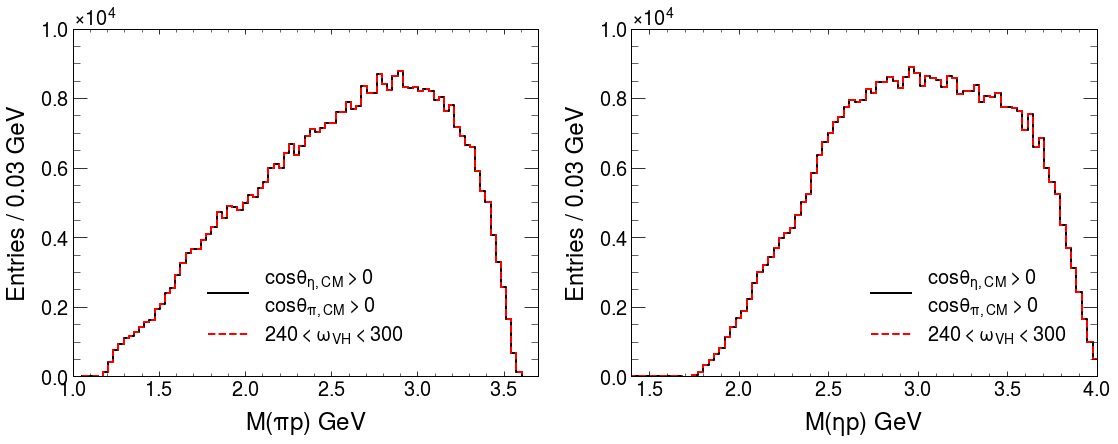

In [11]:
fig,axes=plt.subplots(1,2,figsize=(18,6))

for ax, var, varPretty, axlim in zip(axes,["Mpi0p","Metap"],[r"$M(\pi p)$",r"$M(\eta p)$"], [[1.0, 3.7],[1.40,4.0]]):
    tmp_cm=data_tmp[(data_tmp.cosTheta_eta_cm>0)&(data_tmp.cosTheta_pi0_cm>0)]
    tmp_vh=data_tmp[(data_tmp.vanHove_omega>240)&(data_tmp.vanHove_omega<300)]
    
    edges=np.linspace(data_tmp[var].min(),data_tmp[var].max(),90)
    width=edges[1]-edges[0]
    hep.histplot(np.histogram(tmp_cm[var],weights=tmp_cm.weightASBS,bins=edges),
                 label=r"$cos\theta_{\eta,CM}>0$"+"\n"+r"$cos\theta_{\pi,CM}>0$",c='black',ax=ax)
    hep.histplot(np.histogram(tmp_vh[var],weights=tmp_vh.weightASBS,bins=edges),
                 label=r"$240<\omega_{VH}<300$",c='red',ax=ax,linestyle='--')
    ax.set_ylim(0)
    ax.set_ylim(0)
    ax.set_xlim(*axlim)
    ax.set_xlabel(varPretty+" GeV",size=24)
    ax.legend(prop={"size":20})
    ax.set_ylabel(f"Entries / {width:0.02f} GeV",size=24)

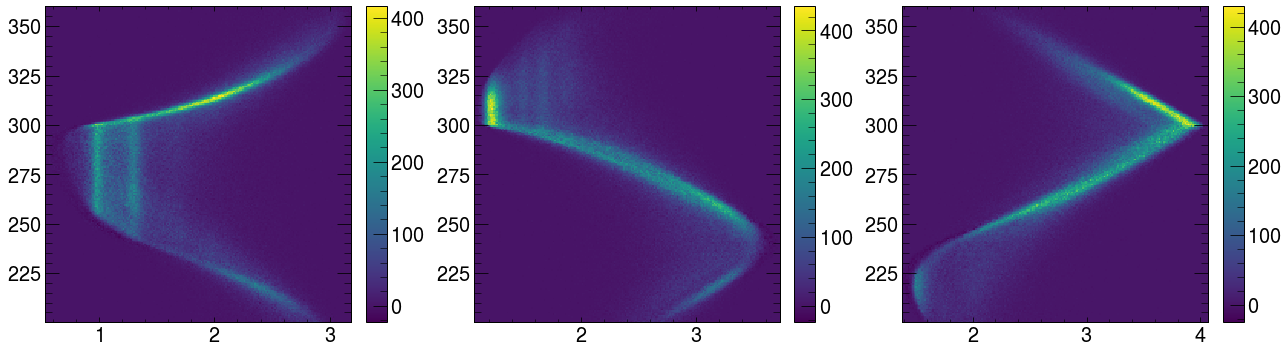

In [12]:
fig,axes=plt.subplots(1,3,figsize=(18,5))
tmp=data_tmp[data_tmp.vanHove_omega>200]
for ax, var in zip(axes,["Mpi0eta","Mpi0p","Metap"]):
    hep.hist2dplot(np.histogram2d(tmp[var],tmp.vanHove_omega,weights=tmp.weightASBS,bins=(200,200)),ax=ax)
plt.tight_layout()

In [13]:
tmp=data_tmp[(data_tmp.Mpi0eta>1.04)&(data_tmp.Mpi0eta<1.80)]
tmp_acc=acc_tmp[(acc_tmp.Mpi0eta>1.04)&(acc_tmp.Mpi0eta<1.80)]
# tmp=data_tmp[(data_tmp.Mpi0eta>1.80)]
# tmp_acc=acc_tmp[(acc_tmp.Mpi0eta>1.80)]


############## IF WE WISHED TO MATCH A VARIABLE BETWEEN TWO DISTRIBUTIONS WE CAN ACCEPT/REJCT #################
# var="mandelstam_t"
# out=np.histogram(tmp[var],weights=tmp.weightASBS,bins=50)
# out_acc=np.histogram(tmp_acc[var],weights=tmp_acc.weightASBS,bins=out[1])
# acceptanceProb=out[0]/out_acc[0]
# def acceptReject(value):
#     i=np.digitize(value,out_acc[1])-1
#     if (i>=0)&(i<len(out_acc[0])):
#         return np.random.uniform(0,1)<acceptanceProb[i]
#     else:
#         return False
# tmp_acc['accepted']=tmp_acc[var].apply(acceptReject)
# tmp_acc_2=tmp_acc[tmp_acc.accepted]

tmp_acc_2=tmp_acc

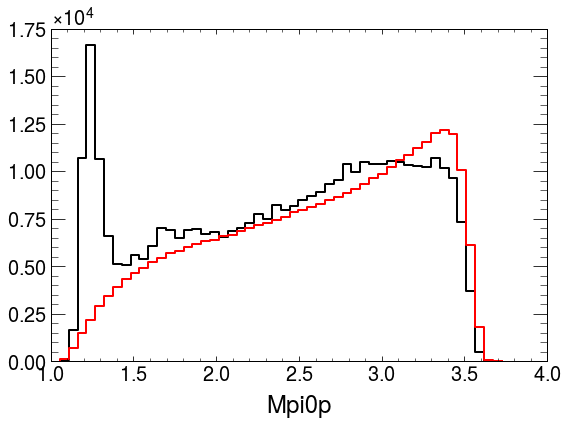

In [14]:
fig,ax=plt.subplots(1,1,figsize=(8,6))

var="Mpi0p"
out=np.histogram(tmp[var],weights=tmp.weightASBS,bins=50)
out_acc_2=np.histogram(tmp_acc_2[var],weights=tmp_acc_2.weightASBS,bins=out[1])

hep.histplot(out,ax=ax,c='black')
hep.histplot((out_acc_2[0]*0.09,out[1]),ax=ax,c='red')
ax.set_ylim(0)
ax.set_xlabel(var)
plt.tight_layout()

Text(0.3, 0.9, '-')

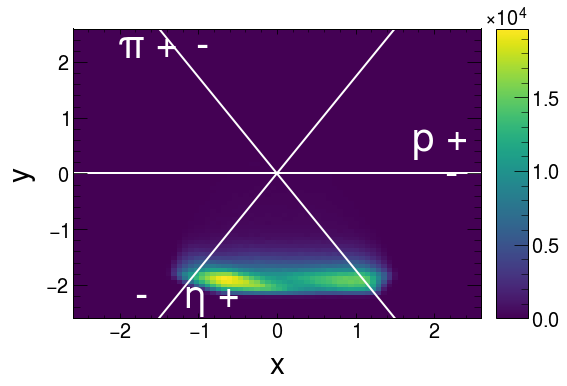

In [15]:
fig,ax=plt.subplots(1,1,figsize=(8,5))

tmp_acc_3=acc_tmp[(acc_tmp.Mpi0eta>1.04)&(acc_tmp.Mpi0eta<1.80)]

edges=(np.linspace(-2.6,2.6,75),np.linspace(-2.6,2.6,75))
hep.hist2dplot(np.histogram2d(x=tmp_acc_3.vanHove_x,y=tmp_acc_3.vanHove_y,weights=tmp_acc_3.weightASBS,bins=edges),ax=ax)
ax.set_xlabel("x",size=30)
ax.set_ylabel("y",size=30)
ax.plot([-2,2],[-2*np.sqrt(3),2*np.sqrt(3)],c='white')
ax.plot([-5,5],[0,0],c='white')
ax.plot([-2,2],[2*np.sqrt(3),-2*np.sqrt(3)],c='white')
ax.text(0.15,0.04,"-",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)
ax.text(0.27,0.04,"$\eta$ +",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)
ax.text(0.83,0.58,"p +",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)
ax.text(0.91,0.46,"-",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)
ax.text(0.11,0.90,r"$\pi$ +",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)
ax.text(0.30,0.90,"-",fontdict={"fontsize":40,'c':'white'},transform=ax.transAxes)

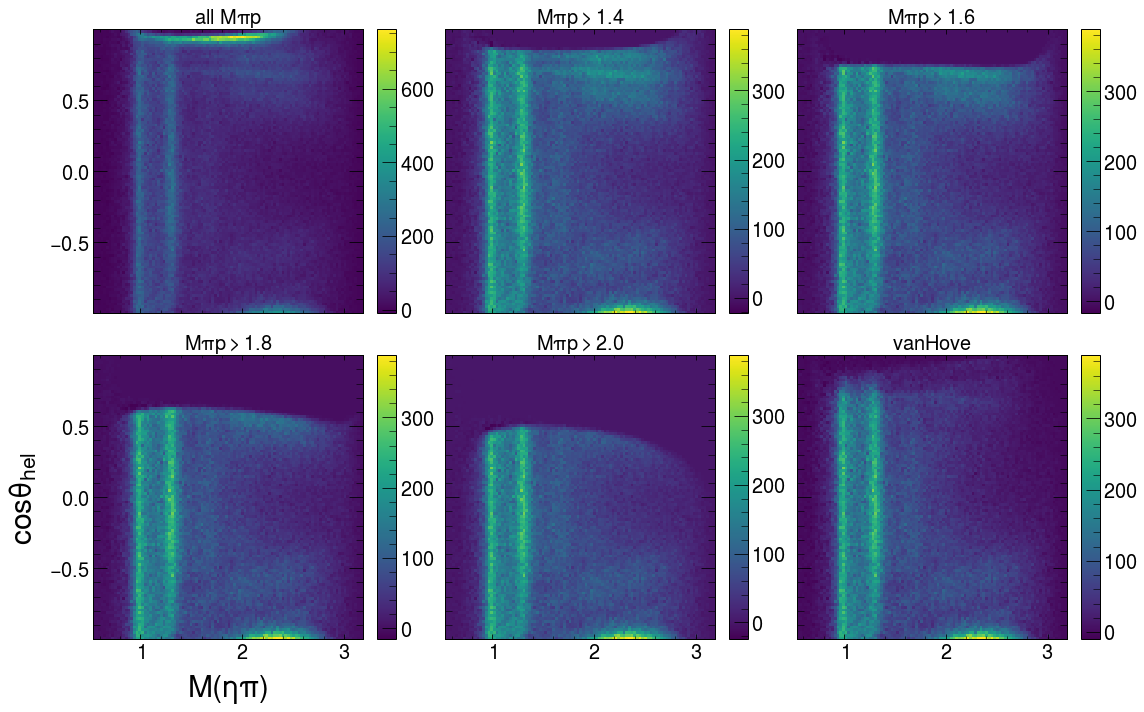

In [16]:
fig,ax=plt.subplots(2,3,figsize=(16,10),sharex=True,sharey=True)
ax=ax.flatten()

out=np.histogram2d(x=data_tmp.Mpi0eta,y=data_tmp.cosTheta_eta_hel,weights=data_tmp.weightASBS,bins=(100,100))
hep.hist2dplot(out,ax=ax[0])
ax[0].set_title("all $M\pi p$")
tmp_2=data_tmp[data_tmp.Mpi0p>1.4]
hep.hist2dplot(np.histogram2d(x=tmp_2.Mpi0eta,y=tmp_2.cosTheta_eta_hel,weights=tmp_2.weightASBS,bins=out[1:]),ax=ax[1])
ax[1].set_title("$M\pi p>1.4$")
tmp_2=data_tmp[data_tmp.Mpi0p>1.6]
hep.hist2dplot(np.histogram2d(x=tmp_2.Mpi0eta,y=tmp_2.cosTheta_eta_hel,weights=tmp_2.weightASBS,bins=out[1:]),ax=ax[2])
ax[2].set_title("$M\pi p>1.6$")
tmp_2=data_tmp[data_tmp.Mpi0p>1.8]
hep.hist2dplot(np.histogram2d(x=tmp_2.Mpi0eta,y=tmp_2.cosTheta_eta_hel,weights=tmp_2.weightASBS,bins=out[1:]),ax=ax[3])
ax[3].set_title("$M\pi p>1.8$")
tmp_2=data_tmp[data_tmp.Mpi0p>2.0]
hep.hist2dplot(np.histogram2d(x=tmp_2.Mpi0eta,y=tmp_2.cosTheta_eta_hel,weights=tmp_2.weightASBS,bins=out[1:]),ax=ax[4])
ax[4].set_title("$M\pi p>2.0$")
tmp_2=data_tmp[data_tmp.pVH]
hep.hist2dplot(np.histogram2d(x=tmp_2.Mpi0eta,y=tmp_2.cosTheta_eta_hel,weights=tmp_2.weightASBS,bins=out[1:]),ax=ax[5])
ax[5].set_title("$vanHove$")


ax[3].set_xlabel(r"M$(\eta\pi)$",size=30)
ax[3].set_ylabel(r"$cos\theta_{hel}$",size=30)
plt.tight_layout()

In [17]:
####################################################
# Compare to QFactors to see if the bump near 1.5 is agreed upon
#    since no delta resonance near 1.5 - answer is yes
#################################################### 

# q_test=loadDF("/d/grid13/ln16/q-values-2/results_data_2018_8_allPols_39/logs/postQVal_flatTree.root",
#               "degALL_data_2018_8_mEllipse_8288_chi13_tpLT05_pipicut_omegacut_tree_flat",
#              cols=["Mpi0eta","cosTheta_eta_gj","mandelstam_tp",
#                  "weightASBS","weightBSpi0","weightBSeta","AccWeight","qvalue",
#                  "Mpi0p","Metap","Mpi0","Meta"]
#              )

# fig,axes=plt.subplots(1,3,figsize=(18,5))
# axes=axes.flatten()
# for iax,var in enumerate(["Mpi0eta","Mpi0p","Metap"]):
#     out=np.histogram(q_test[var],weights=q_test.weightASBS,bins=100)
#     hep.histplot(out,label="Sideband",ax=axes[iax],c='royalblue')
#     hep.histplot(np.histogram(q_test[var],weights=q_test.qvalue*q_test.AccWeight,bins=out[1]),label="QFactor",ax=axes[iax],c='red')
#     axes[iax].set_ylim(0)
#     axes[iax].set_xlabel(var,size=28)
#     axes[iax].set_ylabel("Entries",size=28)

# axes[1].axvline(1.535,c='black',linestyle='--')
# axes[0].legend(prop={"size":22})
# plt.tight_layout()

## -- END SURVERY --

# Pilot Analysis - v0 #

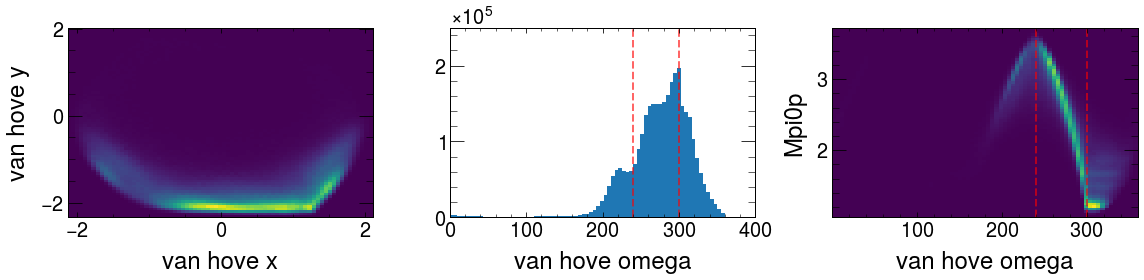

In [9]:
# Van Hove Selections
fig,axes=plt.subplots(1,3,figsize=(16,4))
_=axes[0].hist2d(data_tmp.vanHove_x,data_tmp.vanHove_y,bins=(75,75))
axes[0].set_xlabel("van hove x")
axes[0].set_ylabel("van hove y")
_=axes[1].hist(data_tmp.vanHove_omega,bins=75)
axes[1].set_xlabel("van hove omega")
axes[1].axvline(240,c='red',linestyle='--',alpha=0.6)
axes[1].axvline(300,c='red',linestyle='--',alpha=0.6)
_=axes[2].hist2d(data_tmp.vanHove_omega,data_tmp.Mpi0p,bins=(75,75))
axes[2].set_xlabel("van hove omega")
axes[2].set_ylabel("Mpi0p")
axes[2].axvline(240,c='red',linestyle='--',alpha=0.6)
axes[2].axvline(300,c='red',linestyle='--',alpha=0.6)
plt.tight_layout()

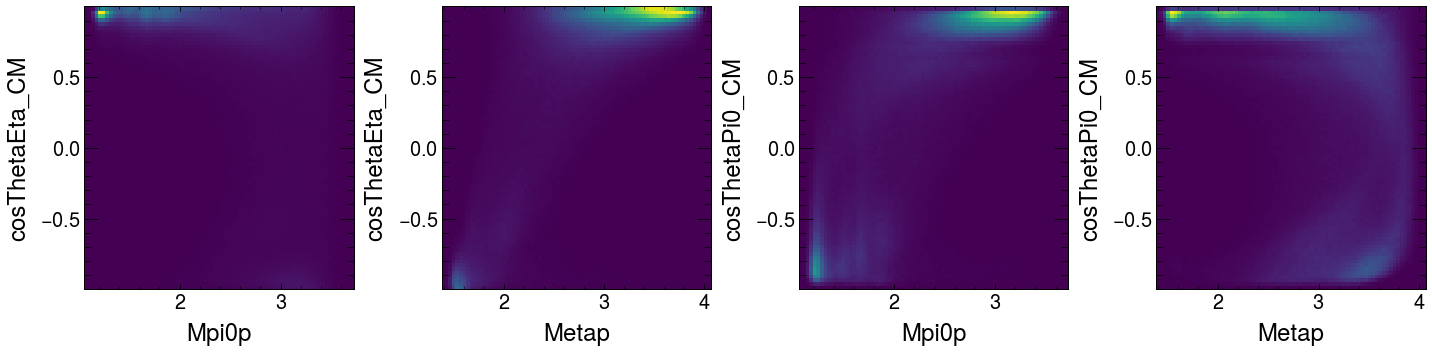

In [10]:
# Cos Theta CM
fig,axes=plt.subplots(1,4,figsize=(20,5))
_=axes[0].hist2d(data_tmp.Mpi0p,data_tmp.cosTheta_eta_cm,bins=(75,75))
axes[0].set_xlabel("Mpi0p")
axes[0].set_ylabel("cosThetaEta_CM")
_=axes[1].hist2d(data_tmp.Metap,data_tmp.cosTheta_eta_cm,bins=(75,75))
axes[1].set_xlabel("Metap")
axes[1].set_ylabel("cosThetaEta_CM")
_=axes[2].hist2d(data_tmp.Mpi0p,data_tmp.cosTheta_pi0_cm,bins=(75,75))
axes[2].set_xlabel("Mpi0p")
axes[2].set_ylabel("cosThetaPi0_CM")
_=axes[3].hist2d(data_tmp.Metap,data_tmp.cosTheta_pi0_cm,bins=(75,75))
axes[3].set_xlabel("Metap")
axes[3].set_ylabel("cosThetaPi0_CM")
plt.tight_layout()

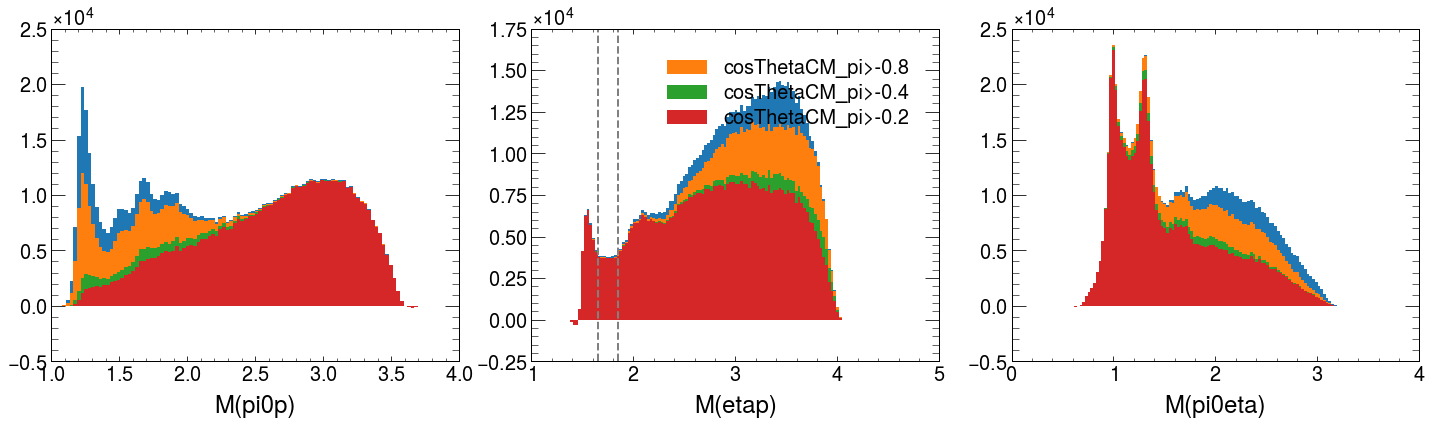

In [11]:
cutVar="cosTheta_pi0_cm"
fig,ax=plt.subplots(1,3,figsize=(20,6))
edges=np.histogram(data_tmp.Mpi0p,bins=100)[1]
_=ax[0].hist(data_tmp.Mpi0p,bins=edges,weights=data_tmp.weightASBS,label="total")
for thresh in [-0.8,-0.4,-0.2]:
    _=ax[0].hist(data_tmp.loc[data_tmp[cutVar]>thresh,"Mpi0p"],bins=edges,weights=data_tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"],
                label="cosThetaCM_pi>"+str(thresh))
ax[0].set_xlabel("M(pi0p)")

edges=np.histogram(data_tmp.Metap,bins=100)[1]
_=ax[1].hist(data_tmp.Metap,bins=edges,weights=data_tmp.weightASBS)
for thresh in [-0.8,-0.4,-0.2]:
    _=ax[1].hist(data_tmp.loc[data_tmp[cutVar]>thresh,"Metap"],bins=edges,weights=data_tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"],
                label="cosThetaCM_pi>"+str(thresh))
ax[1].set_xlabel("M(etap)")
ax[1].legend()
ax[1].axvline(1.65,c='gray',linestyle='--')
ax[1].axvline(1.85,c='gray',linestyle='--')


edges=np.histogram(data_tmp.Mpi0eta,bins=100)[1]
_=ax[2].hist(data_tmp.Mpi0eta,bins=edges,weights=data_tmp.weightASBS)
for thresh in [-0.8,-0.4,-0.2]:
    _=ax[2].hist(data_tmp.loc[data_tmp[cutVar]>thresh,"Mpi0eta"],bins=edges,weights=data_tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"])
ax[2].set_xlabel("M(pi0eta)")

plt.tight_layout()


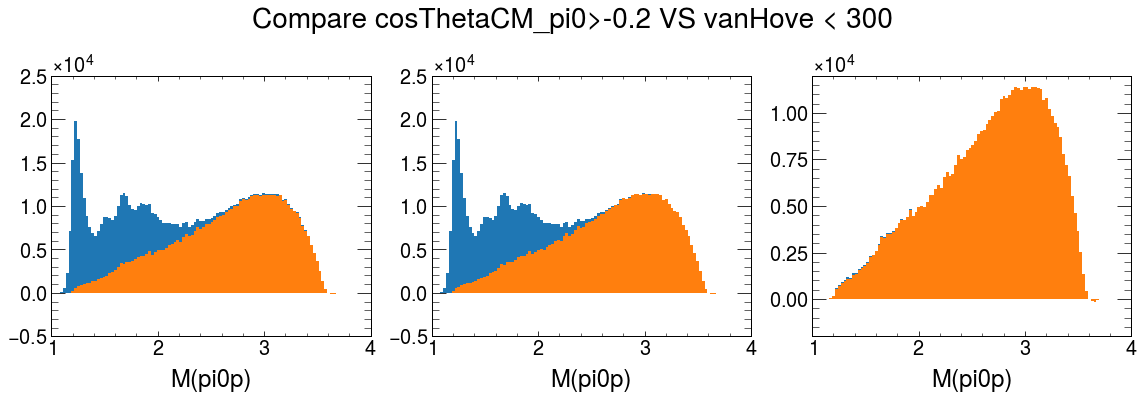

In [12]:
cutVar="cosTheta_pi0_cm"
fig,ax=plt.subplots(1,3,figsize=(16,5))
fig.suptitle("Compare cosThetaCM_pi0>-0.2 VS vanHove < 300",y=1.1)
edges=np.histogram(data_tmp.Mpi0p,bins=100)[1]
thresh=-0.02
_=ax[0].hist(data_tmp.Mpi0p,bins=edges,weights=data_tmp.weightASBS,label="total")
_=ax[0].hist(data_tmp.loc[data_tmp[cutVar]>thresh,"Mpi0p"],bins=edges,weights=data_tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"],label="cut cosThetaCM_pi0")
ax[0].set_xlabel("M(pi0p)")

_=ax[1].hist(data_tmp.Mpi0p,bins=edges,weights=data_tmp.weightASBS,label="total")
_=ax[1].hist(data_tmp.loc[(data_tmp["vanHove_omega"]<300),"Mpi0p"],
             bins=edges,
             weights=data_tmp.loc[(data_tmp["vanHove_omega"]<300),"weightASBS"],label="cut VH omega")
ax[1].set_xlabel("M(pi0p)")

_=ax[2].hist(data_tmp.loc[data_tmp[cutVar]>thresh,"Mpi0p"],bins=edges,weights=data_tmp.loc[data_tmp[cutVar]>thresh,"weightASBS"],label="cut cosThetaCM_pi0")
_=ax[2].hist(data_tmp.loc[(data_tmp["vanHove_omega"]<300),"Mpi0p"],
             bins=edges,
             weights=data_tmp.loc[(data_tmp["vanHove_omega"]<300),"weightASBS"],label="cut VH omega")
ax[2].set_xlabel("M(pi0p)")
plt.tight_layout()

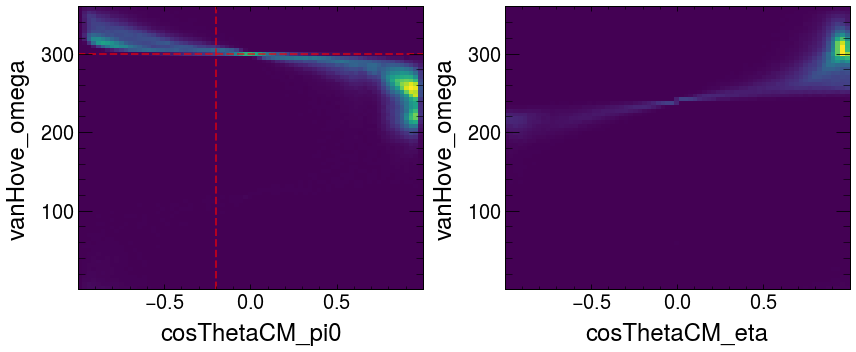

In [13]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
_=axes[0].hist2d(data_tmp["cosTheta_pi0_cm"],data_tmp["vanHove_omega"],bins=(75,75),weights=data_tmp["weightASBS"])
axes[0].set_xlabel("cosThetaCM_pi0")
axes[0].set_ylabel("vanHove_omega")
axes[0].axvline(-0.2,c='red',linestyle='--',alpha=0.6)
axes[0].axhline(300,c='red',linestyle='--',alpha=0.6)

_=axes[1].hist2d(data_tmp["cosTheta_eta_cm"],data_tmp["vanHove_omega"],bins=(75,75),weights=data_tmp["weightASBS"])
axes[1].set_xlabel("cosThetaCM_eta")
axes[1].set_ylabel("vanHove_omega")
plt.tight_layout()

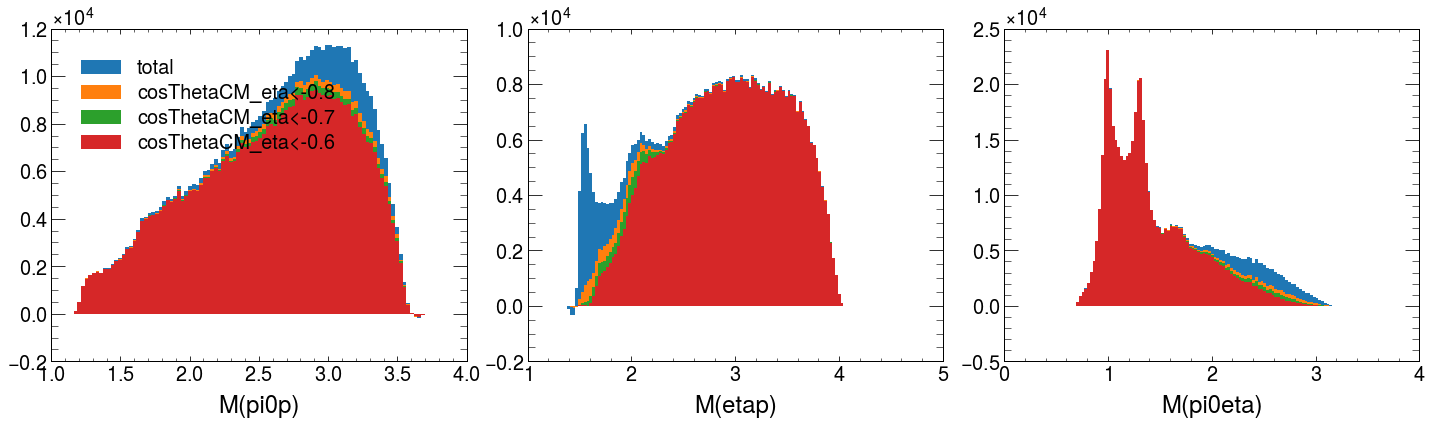

In [20]:
cutVar="cosTheta_eta_cm"
fig,ax=plt.subplots(1,3,figsize=(20,6))
edges=np.histogram(data_tmp.Mpi0p,bins=100)[1]
tmp=data_tmp[data_tmp.cosTheta_pi0_cm>-0.2]

_=ax[0].hist(tmp.Mpi0p,bins=edges,weights=tmp.weightASBS,label="total")
for thresh in [-0.8,-0.7,-0.6]:
    _=ax[0].hist(tmp.loc[tmp[cutVar]>thresh,"Mpi0p"],bins=edges,weights=tmp.loc[tmp[cutVar]>thresh,"weightASBS"],
                label="cosThetaCM_eta<"+str(thresh))
ax[0].set_xlabel("M(pi0p)")
ax[0].legend()

edges=np.histogram(tmp.Metap,bins=100)[1]
_=ax[1].hist(tmp.Metap,bins=edges,weights=tmp.weightASBS)
for thresh in [-0.8,-0.7,-0.6]:
    _=ax[1].hist(tmp.loc[tmp[cutVar]>thresh,"Metap"],bins=edges,weights=tmp.loc[tmp[cutVar]>thresh,"weightASBS"])
ax[1].set_xlabel("M(etap)")

edges=np.histogram(tmp.Mpi0eta,bins=100)[1]
_=ax[2].hist(tmp.Mpi0eta,bins=edges,weights=tmp.weightASBS)
for thresh in [-0.8,-0.7,-0.6]:
    _=ax[2].hist(tmp.loc[tmp[cutVar]>thresh,"Mpi0eta"],bins=edges,weights=tmp.loc[tmp[cutVar]>thresh,"weightASBS"])
ax[2].set_xlabel("M(pi0eta)")

plt.tight_layout()

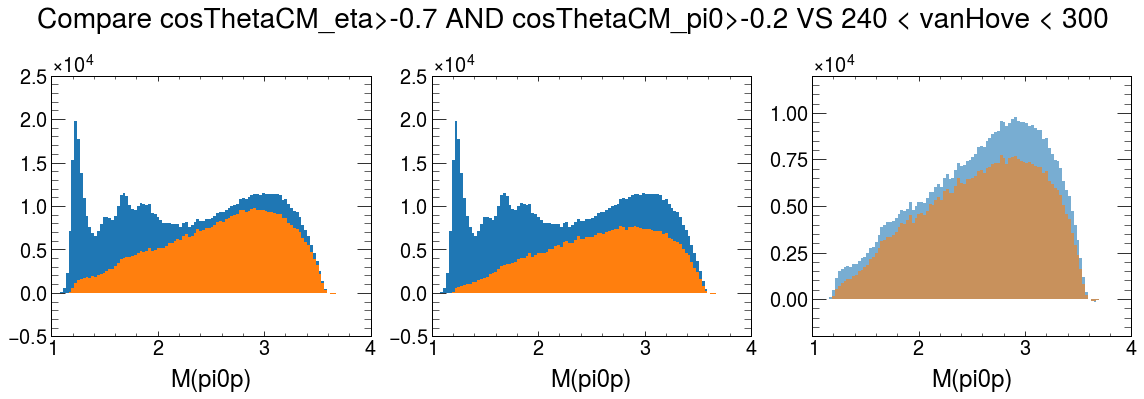

In [21]:
cutVar="cosTheta_pi0_cm"
fig,ax=plt.subplots(1,3,figsize=(16,5))
fig.suptitle("Compare cosThetaCM_eta>-0.7 AND cosThetaCM_pi0>-0.2 VS 240 < vanHove < 300",y=1.1)
edges=np.histogram(data_tmp.Mpi0p,bins=100)[1]
_=ax[0].hist(data_tmp.Mpi0p,bins=edges,weights=data_tmp.weightASBS,label="total")
_=ax[0].hist(data_tmp.loc[(data_tmp["cosTheta_eta_cm"]>-0.7)&(data_tmp["cosTheta_pi0_cm"]>-0.2),"Mpi0p"],bins=edges,
             weights=data_tmp.loc[(data_tmp["cosTheta_eta_cm"]>-0.7)&(data_tmp["cosTheta_pi0_cm"]>-0.2),"weightASBS"],label="cut cosThetaCM_pi0")
ax[0].set_xlabel("M(pi0p)")

_=ax[1].hist(data_tmp.Mpi0p,bins=edges,weights=data_tmp.weightASBS,label="total")
_=ax[1].hist(data_tmp.loc[(data_tmp["vanHove_omega"]>240)&(data_tmp["vanHove_omega"]<300),"Mpi0p"],
             bins=edges,
             weights=data_tmp.loc[(data_tmp["vanHove_omega"]>240)&(data_tmp["vanHove_omega"]<300),"weightASBS"],label="cut VH omega")
ax[1].set_xlabel("M(pi0p)")

_=ax[2].hist(data_tmp.loc[(data_tmp["cosTheta_eta_cm"]>-0.7)&(data_tmp["cosTheta_pi0_cm"]>-0.2),"Mpi0p"],bins=edges, alpha=0.6,
             weights=data_tmp.loc[(data_tmp["cosTheta_eta_cm"]>-0.7)&(data_tmp["cosTheta_pi0_cm"]>-0.2),"weightASBS"],label="cut cosThetaCM_pi0")
_=ax[2].hist(data_tmp.loc[(data_tmp["vanHove_omega"]>240)&(data_tmp["vanHove_omega"]<300),"Mpi0p"],
             bins=edges,
             weights=data_tmp.loc[(data_tmp["vanHove_omega"]>240)&(data_tmp["vanHove_omega"]<300),"weightASBS"],label="cut VH omega",alpha=0.6)
ax[2].set_xlabel("M(pi0p)")
plt.tight_layout()

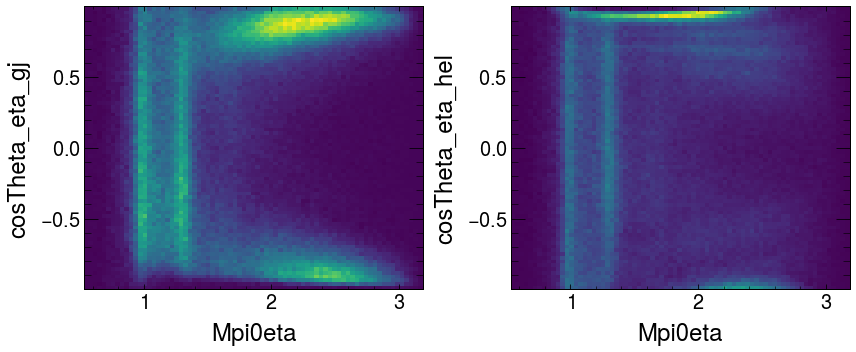

In [22]:
#########
# Full distribution
#########
fig,axes=plt.subplots(1,2,figsize=(12,5))
_=axes[0].hist2d(data_tmp["Mpi0eta"],data_tmp["cosTheta_eta_gj"],bins=(75,75),weights=data_tmp["weightASBS"])
axes[0].set_xlabel("Mpi0eta")
axes[0].set_ylabel("cosTheta_eta_gj")

_=axes[1].hist2d(data_tmp["Mpi0eta"],data_tmp["cosTheta_eta_hel"],bins=(75,75),weights=data_tmp["weightASBS"])
axes[1].set_xlabel("Mpi0eta")
axes[1].set_ylabel("cosTheta_eta_hel")

plt.tight_layout()

No handles with labels found to put in legend.


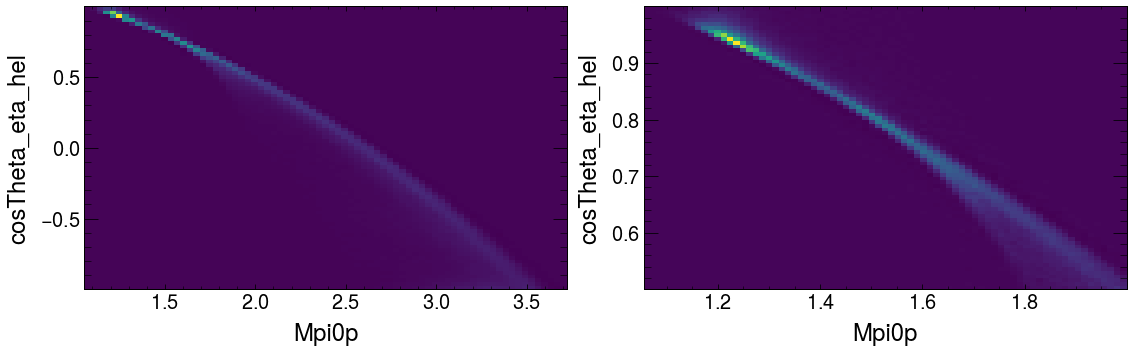

In [24]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
_=ax[0].hist2d(data_tmp["Mpi0p"],data_tmp["cosTheta_eta_hel"],bins=(75,75),weights=data_tmp["weightASBS"])
ax[0].set_ylabel("cosTheta_eta_hel")
ax[0].set_xlabel("Mpi0p")

tmp=data_tmp[(data_tmp["Mpi0p"]<2)*(data_tmp["cosTheta_eta_hel"]>0.5)]
_=ax[1].hist2d(tmp["Mpi0p"],tmp["cosTheta_eta_hel"],bins=(75,75),weights=tmp["weightASBS"])
ax[1].set_ylabel("cosTheta_eta_hel")
ax[1].set_xlabel("Mpi0p")
ax[1].legend(bbox_to_anchor=(1.05,1))

plt.tight_layout()

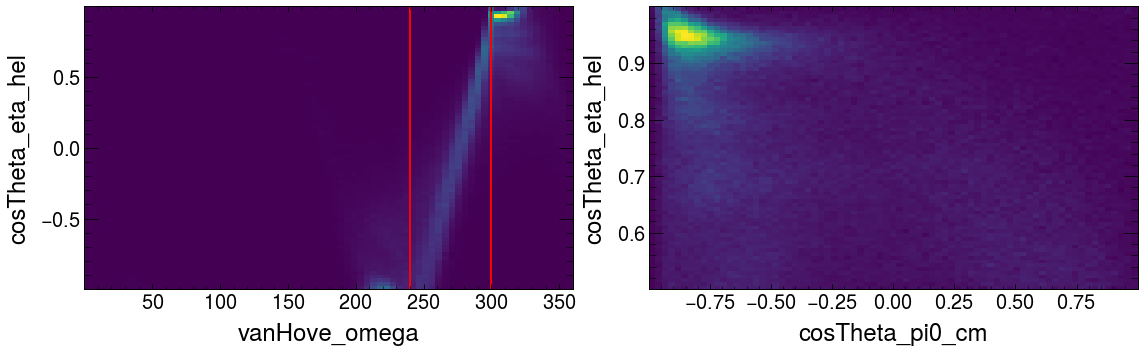

In [25]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
_=ax[0].hist2d(data_tmp["vanHove_omega"],data_tmp["cosTheta_eta_hel"],bins=(75,75),weights=data_tmp["weightASBS"])
ax[0].set_ylabel("cosTheta_eta_hel")
ax[0].set_xlabel("vanHove_omega")
ax[0].axvline(300,c='red')
ax[0].axvline(240,c='red')

_=ax[1].hist2d(tmp["cosTheta_pi0_cm"],tmp["cosTheta_eta_hel"],bins=(75,75),weights=tmp["weightASBS"])
ax[1].set_ylabel("cosTheta_eta_hel")
ax[1].set_xlabel("cosTheta_pi0_cm")

plt.tight_layout()

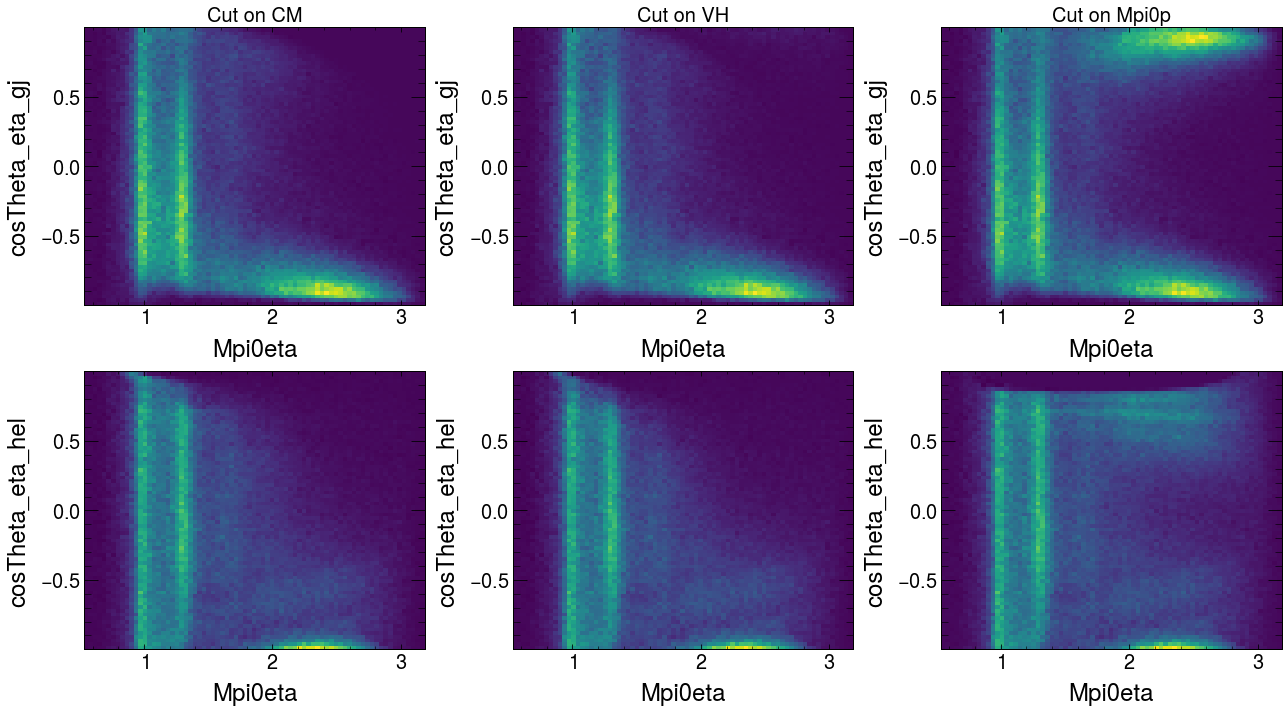

In [26]:
fig,axes=plt.subplots(2,3,figsize=(18,10))

for ivar, var in  enumerate(["cosTheta_eta_gj", "cosTheta_eta_hel"]):
    tmp=data_tmp[data_tmp.cosTheta_pi0_cm>-0.2]
    _=axes[ivar,0].hist2d(tmp["Mpi0eta"],tmp[var],bins=(75,75),weights=tmp["weightASBS"])
    axes[ivar,0].set_xlabel("Mpi0eta")
    axes[ivar,0].set_ylabel(var)
    if ivar==0:
        axes[ivar,0].set_title("Cut on CM")
    
    tmp=data_tmp[data_tmp.vanHove_omega<300]
    _=axes[ivar,1].hist2d(tmp["Mpi0eta"],tmp[var],bins=(75,75),weights=tmp["weightASBS"])
    axes[ivar,1].set_xlabel("Mpi0eta")
    axes[ivar,1].set_ylabel(var)
    if ivar==0:
        axes[ivar,1].set_title("Cut on VH")

    tmp=data_tmp[data_tmp.Mpi0p>1.4]
    _=axes[ivar,2].hist2d(tmp["Mpi0eta"],tmp[var],bins=(75,75),weights=tmp["weightASBS"])
    axes[ivar,2].set_xlabel("Mpi0eta")
    axes[ivar,2].set_ylabel(var)
    if ivar==0:
        axes[ivar,2].set_title("Cut on Mpi0p")
    
plt.tight_layout()

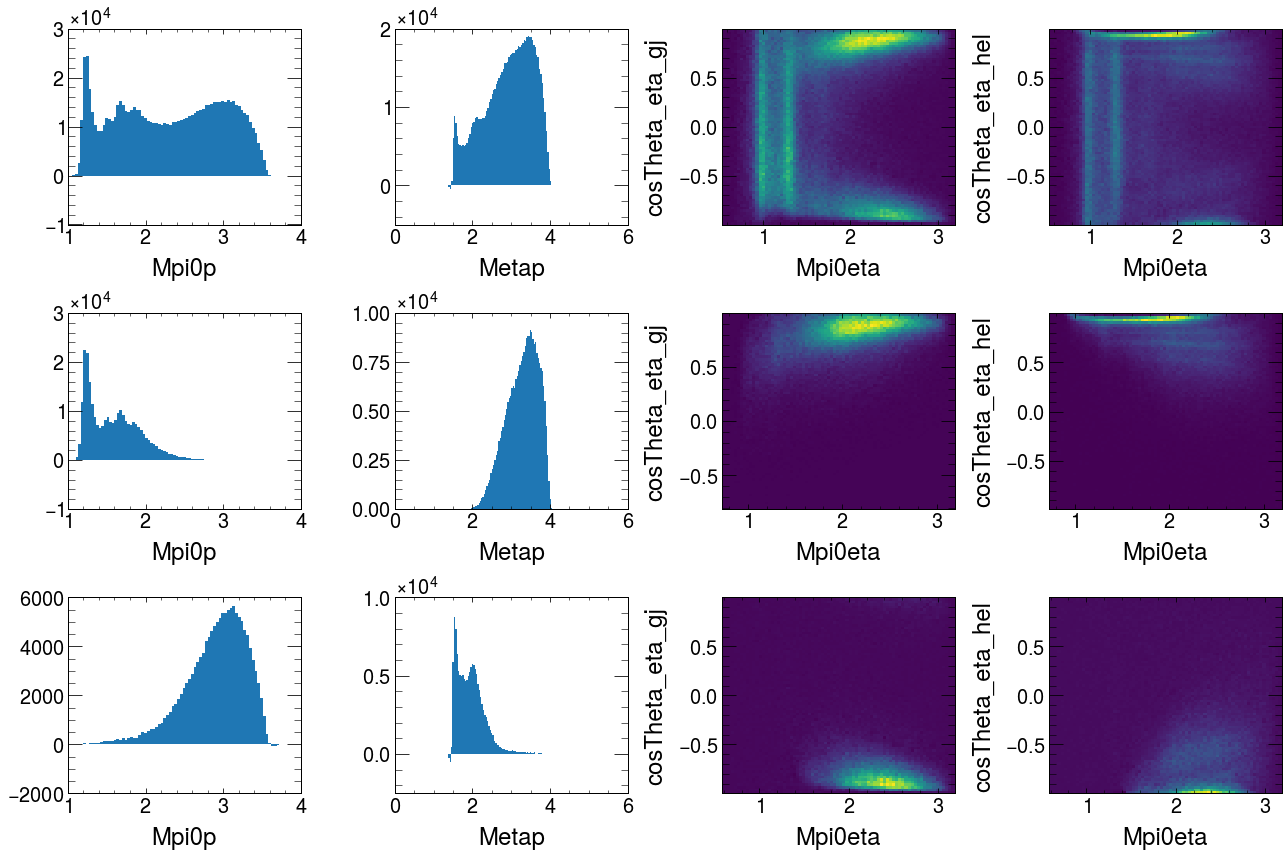

In [27]:
fig,axes=plt.subplots(3,4,figsize=(18,12))

vars=[
    ["Mpi0p"],
    ["Metap"],
    ["Mpi0eta","cosTheta_eta_gj"],
    ["Mpi0eta","cosTheta_eta_hel"]
]

irow=0
for ivar, var in  enumerate(vars):
    tmp=data_tmp#[data_tmp.cosTheta_pi0_cm>-0.2]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])
        
irow=1
for ivar, var in  enumerate(vars):
    tmp=data_tmp[data_tmp.vanHove_omega>300]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])
        
irow=2
for ivar, var in  enumerate(vars):
    tmp=data_tmp[data_tmp.vanHove_omega<240]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])

plt.tight_layout()

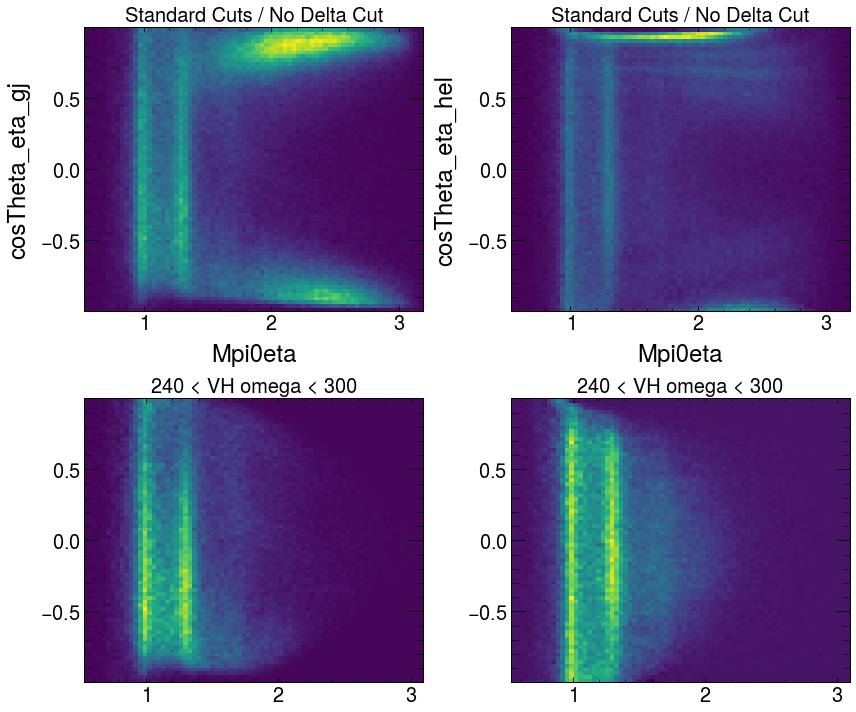

In [28]:
fig,axes=plt.subplots(2,2,figsize=(12,10))
axes=axes.flatten()

_=axes[0].hist2d(data_tmp["Mpi0eta"],data_tmp["cosTheta_eta_gj"],bins=(75,75),weights=data_tmp["weightASBS"])
_=axes[1].hist2d(data_tmp["Mpi0eta"],data_tmp["cosTheta_eta_hel"],bins=(75,75),weights=data_tmp["weightASBS"])
axes[0].set_ylabel("cosTheta_eta_gj")
axes[1].set_ylabel("cosTheta_eta_hel")
axes[0].set_xlabel("Mpi0eta")
axes[1].set_xlabel("Mpi0eta")
axes[0].set_title("Standard Cuts / No Delta Cut")
axes[1].set_title("Standard Cuts / No Delta Cut")

tmp=data_tmp[(data_tmp.vanHove_omega<300)*(data_tmp.vanHove_omega>240)]
_=axes[2].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_gj"],bins=(75,75),weights=tmp["weightASBS"])
_=axes[3].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_hel"],bins=(75,75),weights=tmp["weightASBS"])
axes[2].set_title("240 < VH omega < 300")
axes[3].set_title("240 < VH omega < 300")

plt.tight_layout()

/d/home/ln16/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


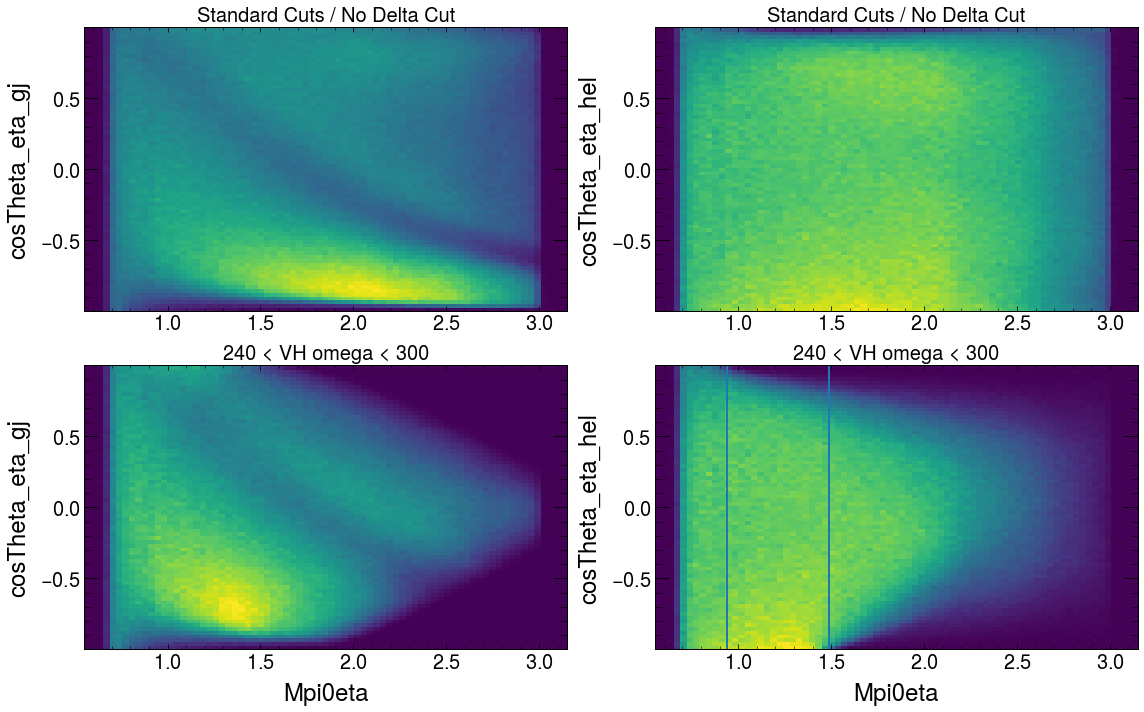

In [39]:
fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

_=axes[0].hist2d(acc_tmp["Mpi0eta"],acc_tmp["cosTheta_eta_gj"],bins=(75,75),weights=acc_tmp["weightASBS"])
_=axes[1].hist2d(acc_tmp["Mpi0eta"],acc_tmp["cosTheta_eta_hel"],bins=(75,75),weights=acc_tmp["weightASBS"])
axes[0].set_title("Standard Cuts / No Delta Cut")
axes[1].set_title("Standard Cuts / No Delta Cut")

tmp=acc_tmp[(acc_tmp.vanHove_omega<300)*(acc_tmp.vanHove_omega>240)]
_=axes[2].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_gj"],bins=(75,75),weights=tmp["weightASBS"])
_=axes[3].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_hel"],bins=(75,75),weights=tmp["weightASBS"])
axes[2].set_title("240 < VH omega < 300")
axes[3].set_title("240 < VH omega < 300")
axes[3].axvline(0.938+0.55,label="Mass=0.938+0.55")
axes[3].axvline(0.938,label="Mass=0.938")

axes[0].set_ylabel("cosTheta_eta_gj")
axes[1].set_ylabel("cosTheta_eta_hel")
axes[2].set_ylabel("cosTheta_eta_gj")
axes[3].set_ylabel("cosTheta_eta_hel")
axes[2].set_xlabel("Mpi0eta")
axes[3].set_xlabel("Mpi0eta")

plt.tight_layout()

In [32]:
tmp=data_tmp[data_tmp.Mpi0p<1.4]
counts,edgex,edgey=np.histogram2d(tmp["Mpi0eta"],tmp["vanHove_omega"],bins=edges)

In [33]:
def getSigma(col,lowPercentile=16,upPercentile=84):
    gtzero=np.where(col>0)[0]
    if len(gtzero)>0:
        col=col[gtzero]
        edge=edgey[gtzero]
        flattened=[]
        for i in range(len(col)):
            flattened.extend([edge[i]]*int(col[i]))
        flattened=np.array(flattened)
        lower=np.percentile(flattened,lowPercentile)
        median=np.percentile(flattened,50)
        upper=np.percentile(flattened,upPercentile)
    else:
        lower,upper,median=(0,0,0)
    return lower,upper,median

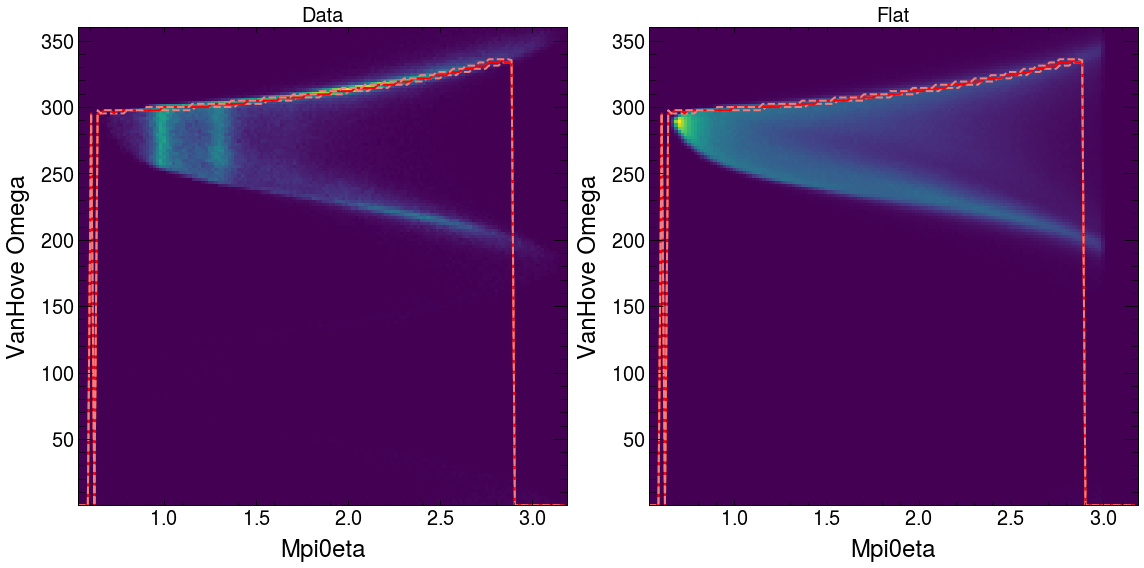

In [34]:
fig,axes=plt.subplots(1,2,figsize=(16,8))
edges=np.histogram2d(data_tmp["Mpi0eta"],data_tmp["vanHove_omega"],bins=(150,150))[1:]
_=axes[0].hist2d(data_tmp["Mpi0eta"],data_tmp["vanHove_omega"],bins=edges,weights=data_tmp["weightASBS"],vmin=0)
axes[0].set_xlabel("Mpi0eta")
axes[0].set_ylabel("VanHove Omega")
axes[0].set_title("Data")

tmp=data_tmp[(data_tmp.Mpi0p<1.4)]
counts,edgex,edgey=np.histogram2d(tmp["Mpi0eta"],tmp["vanHove_omega"],bins=edges)
lowers=[]
uppers=[]
medians=[]
for col in range(len(counts)):
    lower,upper,median=getSigma(counts[col,:])
    lowers.append(lower)
    uppers.append(upper)
    medians.append(median)
axes[0].plot(edgex[:-1],lowers,c='lightcoral',linestyle='--')
axes[0].plot(edgex[:-1],medians,c='red',linestyle='-')
axes[0].plot(edgex[:-1],uppers,c='lightcoral',linestyle='--')


_=axes[1].hist2d(acc_tmp["Mpi0eta"],acc_tmp["vanHove_omega"],bins=edges,weights=acc_tmp["weightASBS"],vmin=0)
axes[1].set_xlabel("Mpi0eta")
axes[1].set_ylabel("VanHove Omega")
axes[1].set_title("Flat")
axes[1].plot(edgex[:-1],lowers,c='lightcoral',linestyle='--')
axes[1].plot(edgex[:-1],medians,c='red',linestyle='-')
axes[1].plot(edgex[:-1],uppers,c='lightcoral',linestyle='--')

plt.tight_layout()

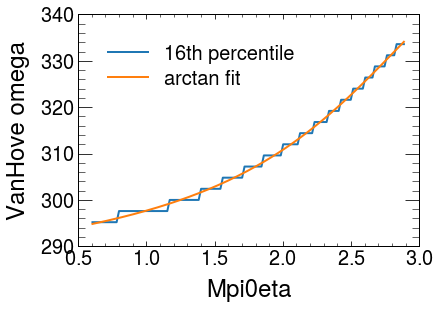

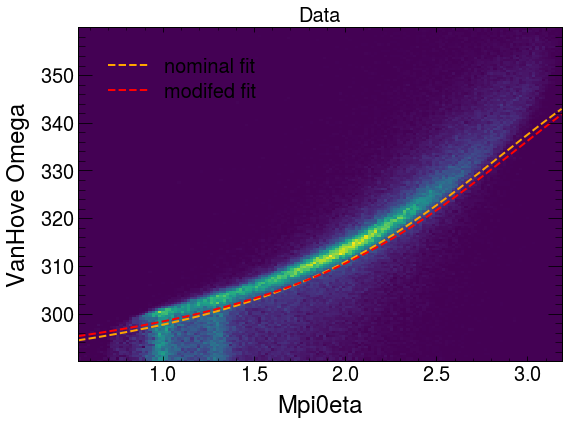

In [35]:
from scipy.optimize import curve_fit

def arctan(x,a,b,c,d):
    return a*np.arctan(b*(x-c))+d

percentiles=lowers
percentiles=np.array(percentiles)
percentilesGT0=np.where(percentiles>0)
percentiles=percentiles[percentilesGT0]
edges=edgex[:-1][percentilesGT0]
popt, pcov = curve_fit(arctan, edges, percentiles, p0=[-34.40782804,  -0.85071669,   2.77821283, 334.47225961])
plt.plot(edges,percentiles,label='16th percentile')
plt.plot(edges,arctan(edges,*popt),label='arctan fit')
plt.xlabel("Mpi0eta")
plt.ylabel("VanHove omega")
plt.legend()

########
# Modify the fit abit since it looks like it can perform better at low mass
########
fig,axes=plt.subplots(1,1,figsize=(8,6))

tmp=data_tmp[data_tmp.vanHove_omega>290]

edges=np.histogram2d(tmp["Mpi0eta"],tmp["vanHove_omega"],bins=(150,150))[1:]
_=axes.hist2d(tmp["Mpi0eta"],tmp["vanHove_omega"],bins=edges,weights=tmp["weightASBS"],vmin=0)
axes.set_xlabel("Mpi0eta")
axes.set_ylabel("VanHove Omega")
axes.set_title("Data")
axes.plot(edges[0],arctan(edges[0],*popt),c='orange',linestyle='--',label='nominal fit')
popt[2]+=0.09
popt[3]+=1.4
axes.plot(edges[0],arctan(edges[0],*popt),c='red',linestyle='--',label="modifed fit")
axes.legend()

plt.tight_layout()

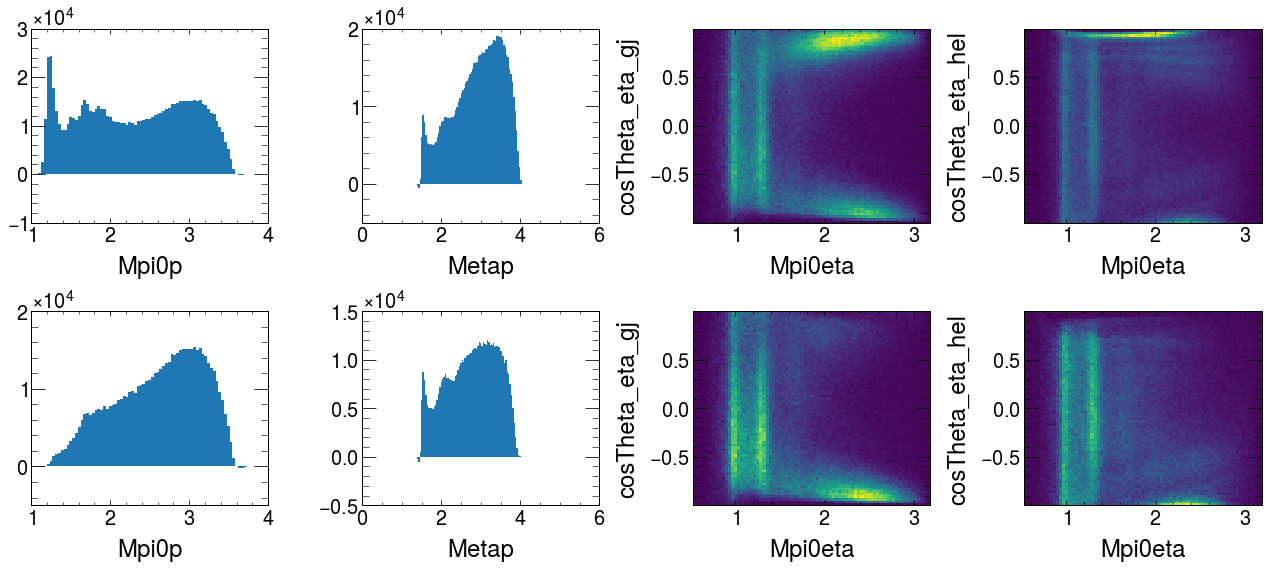

In [36]:
wanted_omega=arctan(data_tmp.Mpi0eta,*popt)
data_vh_selected=data_tmp[data_tmp.vanHove_omega<wanted_omega]

fig,axes=plt.subplots(2,4,figsize=(18,8))

vars=[
    ["Mpi0p"],
    ["Metap"],
    ["Mpi0eta","cosTheta_eta_gj"],
    ["Mpi0eta","cosTheta_eta_hel"]
]

irow=0
for ivar, var in  enumerate(vars):
    tmp=data_tmp#[data_tmp.cosTheta_pi0_cm>-0.2]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])

irow=1
for ivar, var in  enumerate(vars):
    tmp=data_vh_selected#[data_tmp.cosTheta_pi0_cm>-0.2]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])

        
plt.tight_layout()

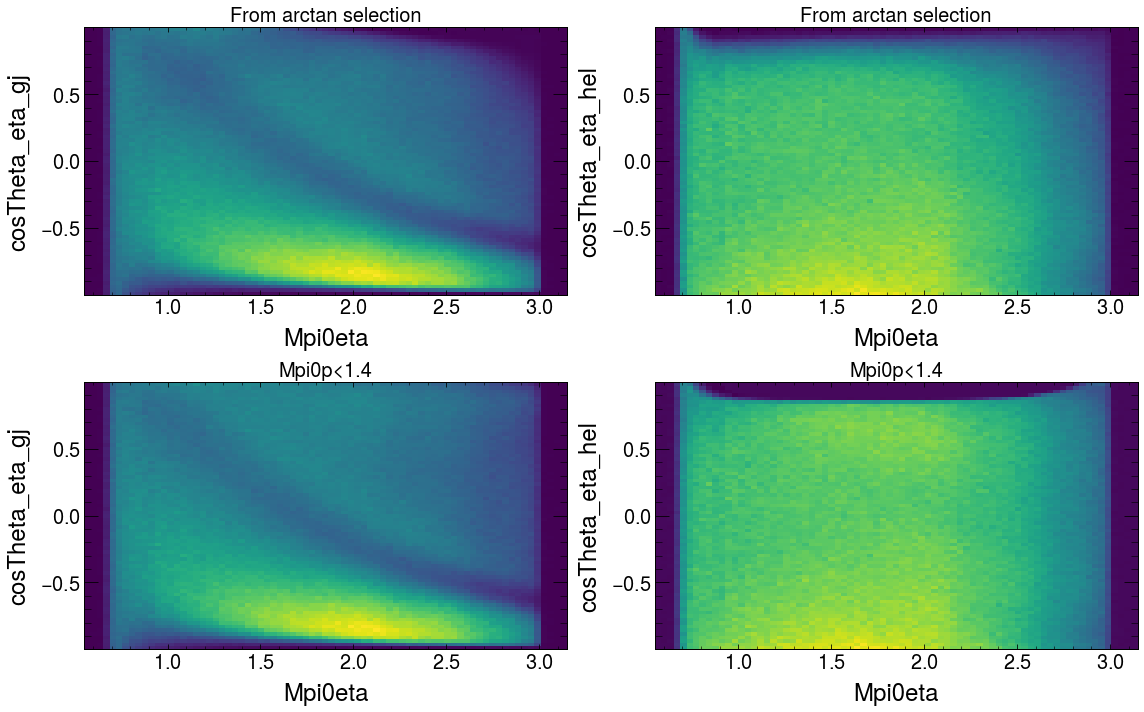

In [37]:
wanted_omega=arctan(acc_tmp.Mpi0eta,*popt)
acc_vh_selected=acc_tmp[acc_tmp.vanHove_omega<wanted_omega]

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

_=axes[0].hist2d(acc_vh_selected["Mpi0eta"],acc_vh_selected["cosTheta_eta_gj"],bins=(75,75),weights=acc_vh_selected["weightASBS"])
_=axes[1].hist2d(acc_vh_selected["Mpi0eta"],acc_vh_selected["cosTheta_eta_hel"],bins=(75,75),weights=acc_vh_selected["weightASBS"])
axes[0].set_ylabel("cosTheta_eta_gj")
axes[1].set_ylabel("cosTheta_eta_hel")
axes[0].set_xlabel("Mpi0eta")
axes[1].set_xlabel("Mpi0eta")
axes[0].set_title("From arctan selection")
axes[1].set_title("From arctan selection")

tmp=acc_tmp[acc_tmp.Mpi0p>1.4]
_=axes[2].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_gj"],bins=(75,75),weights=tmp["weightASBS"])
_=axes[3].hist2d(tmp["Mpi0eta"],tmp["cosTheta_eta_hel"],bins=(75,75),weights=tmp["weightASBS"])
axes[2].set_ylabel("cosTheta_eta_gj")
axes[3].set_ylabel("cosTheta_eta_hel")
axes[2].set_xlabel("Mpi0eta")
axes[3].set_xlabel("Mpi0eta")
axes[2].set_title("Mpi0p<1.4")
axes[3].set_title("Mpi0p<1.4")

plt.tight_layout()

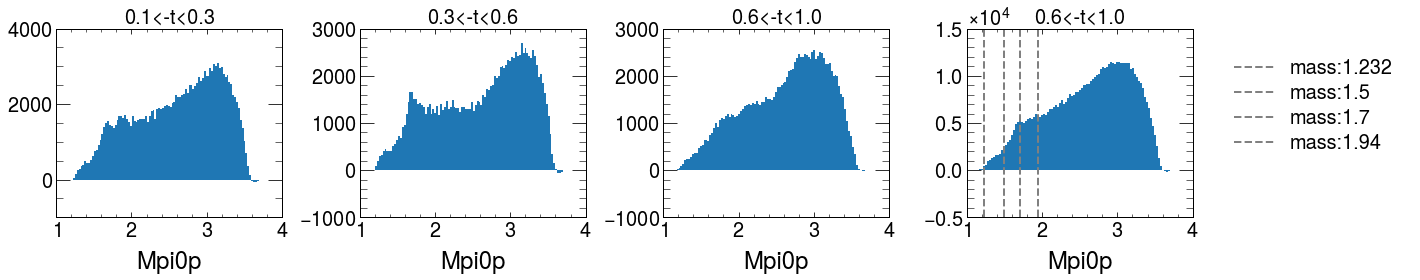

In [40]:
fig,axes=plt.subplots(1,4,figsize=(20,4))
_=axes[0].hist(data_vh_selected.loc[(data_vh_selected.mandelstam_t<0.3)&(data_vh_selected.mandelstam_t>0.1),"Mpi0p"],
               bins=100,
               weights=data_vh_selected.loc[(data_vh_selected.mandelstam_t<0.3)&(data_vh_selected.mandelstam_t>0.1),"weightASBS"])
axes[0].set_xlabel("Mpi0p")
axes[0].set_title(label="0.1<-t<0.3")

_=axes[1].hist(data_vh_selected.loc[(data_vh_selected.mandelstam_t<0.6)&(data_vh_selected.mandelstam_t>0.3),"Mpi0p"],
               bins=100,
               weights=data_vh_selected.loc[(data_vh_selected.mandelstam_t<0.6)&(data_vh_selected.mandelstam_t>0.3),"weightASBS"])
axes[1].set_xlabel("Mpi0p")
axes[1].set_title(label="0.3<-t<0.6")

_=axes[2].hist(data_vh_selected.loc[(data_vh_selected.mandelstam_t<1.0)&(data_vh_selected.mandelstam_t>0.6),"Mpi0p"],
               bins=100,
               weights=data_vh_selected.loc[(data_vh_selected.mandelstam_t<1.0)&(data_vh_selected.mandelstam_t>0.6),"weightASBS"])
axes[2].set_xlabel("Mpi0p")
axes[2].set_title(label="0.6<-t<1.0")

_=axes[3].hist(data_vh_selected["Mpi0p"],
               bins=100,
               weights=data_vh_selected["weightASBS"])
axes[3].set_xlabel("Mpi0p")
axes[3].set_title(label="0.6<-t<1.0")
for res_mass in known_resonances:
    axes[3].axvline(res_mass,c='gray',linestyle='--',label="mass:{0}".format(res_mass))
axes[3].legend(bbox_to_anchor=(1.05,1))

plt.tight_layout()

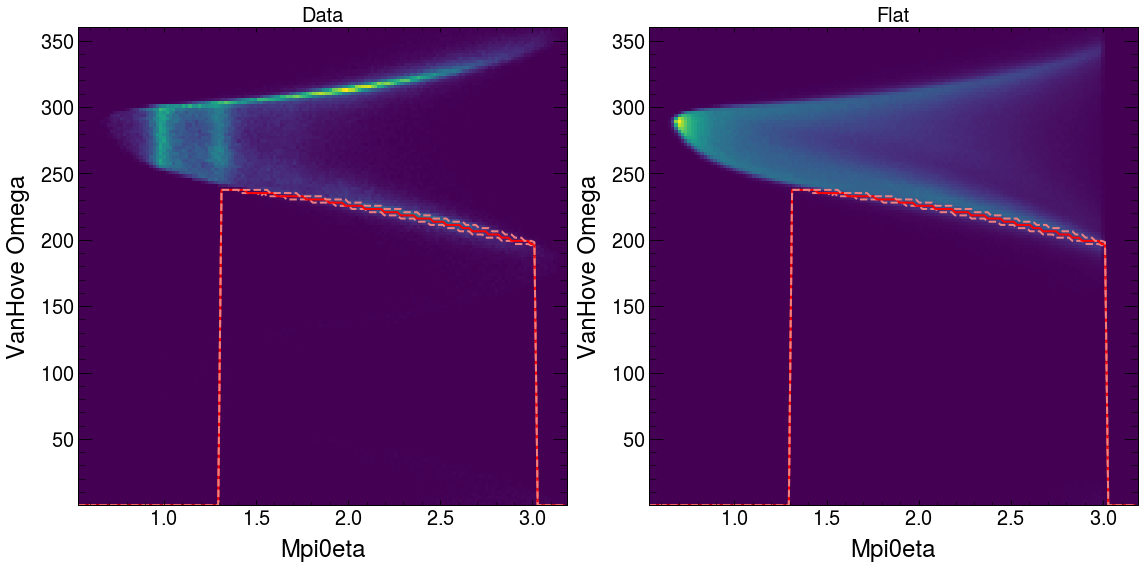

In [41]:
fig,axes=plt.subplots(1,2,figsize=(16,8))
edges=np.histogram2d(data_tmp["Mpi0eta"],data_tmp["vanHove_omega"],bins=(150,150))[1:]
_=axes[0].hist2d(data_tmp["Mpi0eta"],data_tmp["vanHove_omega"],bins=edges,weights=data_tmp["weightASBS"],vmin=0)
axes[0].set_xlabel("Mpi0eta")
axes[0].set_ylabel("VanHove Omega")
axes[0].set_title("Data")

tmp=data_tmp[(data_tmp.Metap<1.65)]
counts,edgex,edgey=np.histogram2d(tmp["Mpi0eta"],tmp["vanHove_omega"],bins=edges)
lowers=[]
uppers=[]
medians=[]
for col in range(len(counts)):
    lower,upper,median=getSigma(counts[col,:],16,90)
    lowers.append(lower)
    uppers.append(upper)
    medians.append(median)
axes[0].plot(edgex[:-1],lowers,c='lightcoral',linestyle='--')
axes[0].plot(edgex[:-1],medians,c='red',linestyle='-')
axes[0].plot(edgex[:-1],uppers,c='lightcoral',linestyle='--')


_=axes[1].hist2d(acc_tmp["Mpi0eta"],acc_tmp["vanHove_omega"],bins=edges,weights=acc_tmp["weightASBS"],vmin=0)
axes[1].set_xlabel("Mpi0eta")
axes[1].set_ylabel("VanHove Omega")
axes[1].set_title("Flat")
axes[1].plot(edgex[:-1],lowers,c='lightcoral',linestyle='--')
axes[1].plot(edgex[:-1],medians,c='red',linestyle='-')
axes[1].plot(edgex[:-1],uppers,c='lightcoral',linestyle='--')

plt.tight_layout()

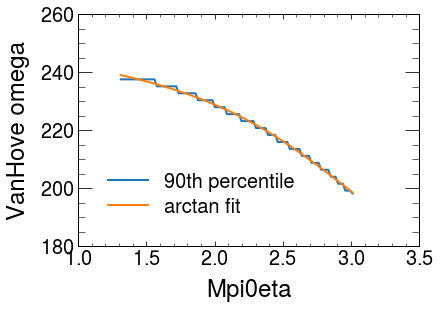

In [42]:
from scipy.optimize import curve_fit

def arctan(x,a,b,c,d):
    return a*np.arctan(b*(x-c))+d

percentiles=uppers
percentiles=np.array(percentiles)
percentilesGT0=np.where(percentiles>0)
percentiles=percentiles[percentilesGT0]
edges=edgex[:-1][percentilesGT0]
popt2, pcov = curve_fit(arctan, edges, percentiles, p0=[43.90795447,  -0.86608286,   3.08704162, 195.64804878])
plt.plot(edges,percentiles,label='90th percentile')
plt.plot(edges,arctan(edges,*popt2),label='arctan fit')
plt.xlabel("Mpi0eta")
plt.ylabel("VanHove omega")
plt.legend()

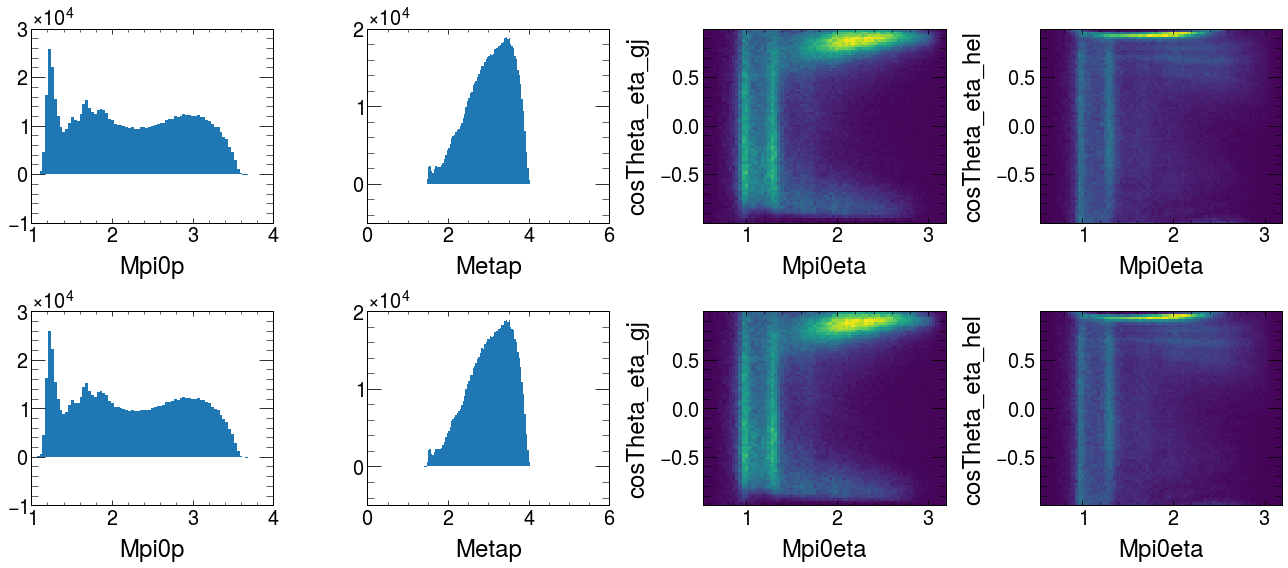

In [43]:
wanted_omega2=arctan(data_tmp.Mpi0eta,*popt2)
data_vh_selected=data_tmp[data_tmp.vanHove_omega>wanted_omega2]

fig,axes=plt.subplots(2,4,figsize=(18,8))

vars=[
    ["Mpi0p"],
    ["Metap"],
    ["Mpi0eta","cosTheta_eta_gj"],
    ["Mpi0eta","cosTheta_eta_hel"]
]

irow=0
for ivar, var in  enumerate(vars):
    tmp=data_vh_selected#[data_tmp.cosTheta_pi0_cm>-0.2]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])

irow=1
for ivar, var in  enumerate(vars):
    tmp=data_vh_selected#[data_tmp.cosTheta_pi0_cm>-0.2]
    if len(var)==1:
        _=axes[irow,ivar].hist(tmp[var[0]],bins=75,weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
    else:
        _=axes[irow,ivar].hist2d(tmp[var[0]],tmp[var[1]],bins=(75,75),weights=tmp["weightASBS"])
        axes[irow,ivar].set_xlabel(var[0])
        axes[irow,ivar].set_ylabel(var[1])

        
plt.tight_layout()

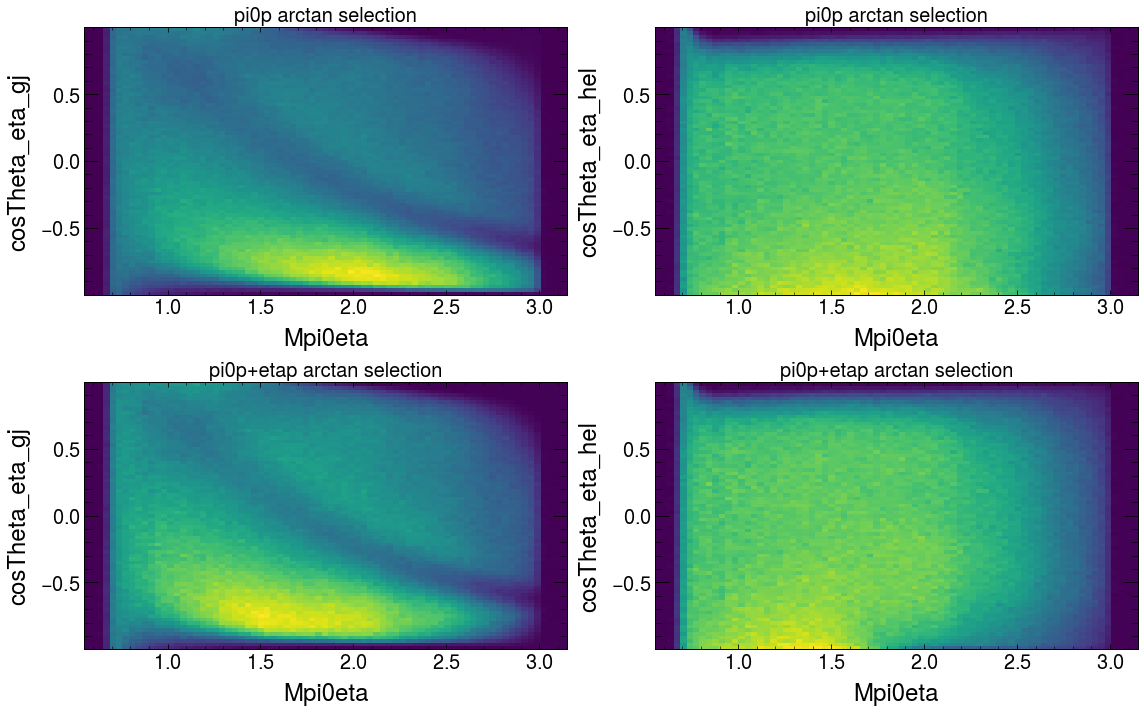

In [44]:
wanted_omega=arctan(acc_tmp.Mpi0eta,*popt)
acc_vh_selected=acc_tmp[acc_tmp.vanHove_omega<wanted_omega]
wanted_omega2=arctan(acc_tmp.Mpi0eta,*popt2)
acc_vh_selected2=acc_tmp[(acc_tmp.vanHove_omega<wanted_omega)&(acc_tmp.vanHove_omega>wanted_omega2)]

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

_=axes[0].hist2d(acc_vh_selected["Mpi0eta"],acc_vh_selected["cosTheta_eta_gj"],bins=(75,75),weights=acc_vh_selected["weightASBS"])
_=axes[1].hist2d(acc_vh_selected["Mpi0eta"],acc_vh_selected["cosTheta_eta_hel"],bins=(75,75),weights=acc_vh_selected["weightASBS"])
axes[0].set_ylabel("cosTheta_eta_gj")
axes[1].set_ylabel("cosTheta_eta_hel")
axes[0].set_xlabel("Mpi0eta")
axes[1].set_xlabel("Mpi0eta")
axes[0].set_title("pi0p arctan selection")
axes[1].set_title("pi0p arctan selection")

_=axes[2].hist2d(acc_vh_selected2["Mpi0eta"],acc_vh_selected2["cosTheta_eta_gj"],bins=(75,75),weights=acc_vh_selected2["weightASBS"])
_=axes[3].hist2d(acc_vh_selected2["Mpi0eta"],acc_vh_selected2["cosTheta_eta_hel"],bins=(75,75),weights=acc_vh_selected2["weightASBS"])
axes[2].set_ylabel("cosTheta_eta_gj")
axes[3].set_ylabel("cosTheta_eta_hel")
axes[2].set_xlabel("Mpi0eta")
axes[3].set_xlabel("Mpi0eta")
axes[2].set_title("pi0p+etap arctan selection")
axes[3].set_title("pi0p+etap arctan selection")

plt.tight_layout()

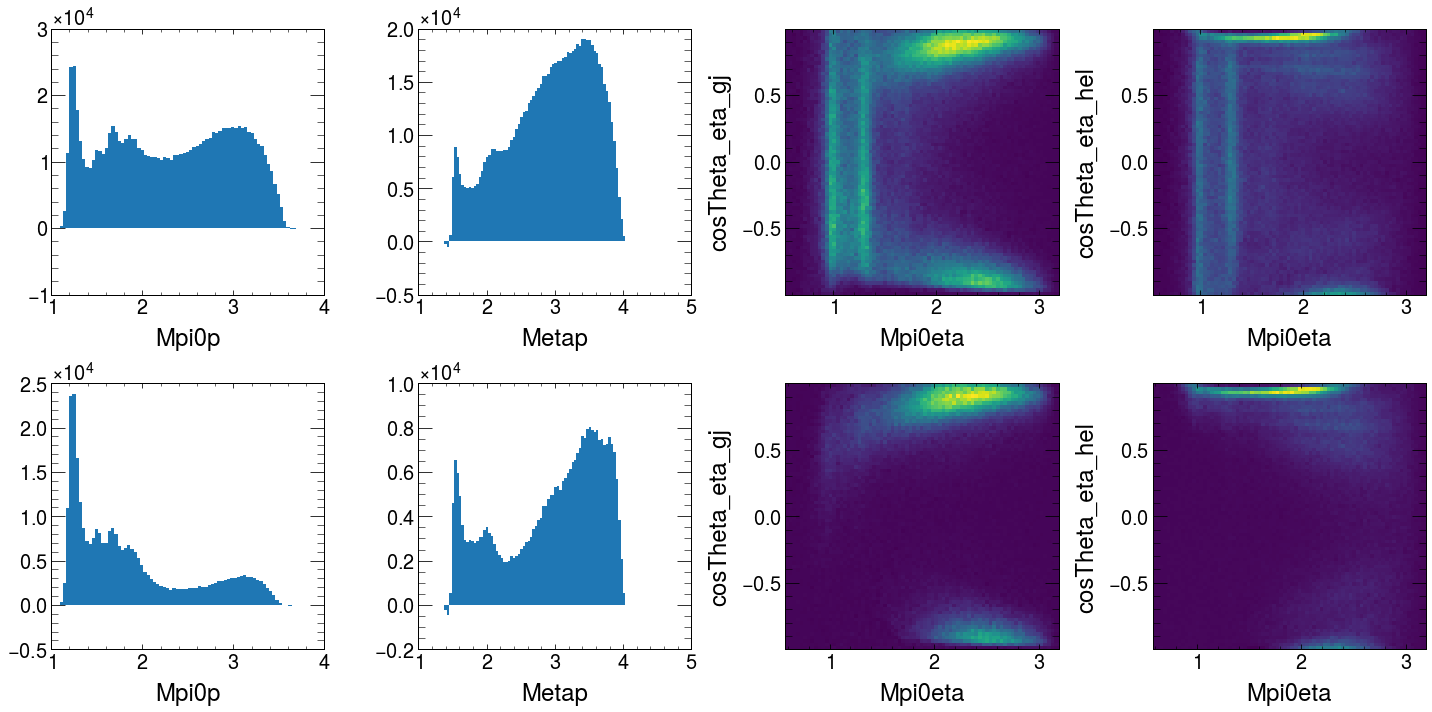

In [45]:
fig,axes=plt.subplots(2,4,figsize=(20,10))
axes=axes.flatten()

# Standard selections with Delta in
axes[0].hist(data_tmp.Mpi0p,bins=75,weights=data_tmp.weightASBS)
axes[0].set_xlabel("Mpi0p")
axes[1].hist(data_tmp.Metap,bins=75,weights=data_tmp.weightASBS)
axes[1].set_xlabel("Metap")
axes[2].hist2d(data_tmp.Mpi0eta,data_tmp.cosTheta_eta_gj,bins=(75,75),weights=data_tmp.weightASBS)
axes[2].set_xlabel("Mpi0eta")
axes[2].set_ylabel("cosTheta_eta_gj")
axes[3].hist2d(data_tmp.Mpi0eta,data_tmp.cosTheta_eta_hel,bins=(75,75),weights=data_tmp.weightASBS)
axes[3].set_xlabel("Mpi0eta")
axes[3].set_ylabel("cosTheta_eta_hel")

# What I propose to remove
wanted_omega=arctan(data_tmp.Mpi0eta,*popt)
wanted_omega2=arctan(data_tmp.Mpi0eta,*popt2)
data_vh_selected_2=data_tmp[(data_tmp.vanHove_omega>wanted_omega)|(data_tmp.vanHove_omega<wanted_omega2)]

axes[4].hist(data_vh_selected_2.Mpi0p,bins=75,weights=data_vh_selected_2.weightASBS)
axes[4].set_xlabel("Mpi0p")
axes[5].hist(data_vh_selected_2.Metap,bins=75,weights=data_vh_selected_2.weightASBS)
axes[5].set_xlabel("Metap")
axes[6].hist2d(data_vh_selected_2.Mpi0eta,data_vh_selected_2.cosTheta_eta_gj,bins=(75,75),weights=data_vh_selected_2.weightASBS)
axes[6].set_xlabel("Mpi0eta")
axes[6].set_ylabel("cosTheta_eta_gj")
axes[7].hist2d(data_vh_selected_2.Mpi0eta,data_vh_selected_2.cosTheta_eta_hel,bins=(75,75),weights=data_vh_selected_2.weightASBS)
axes[7].set_xlabel("Mpi0eta")
axes[7].set_ylabel("cosTheta_eta_hel")
plt.tight_layout()

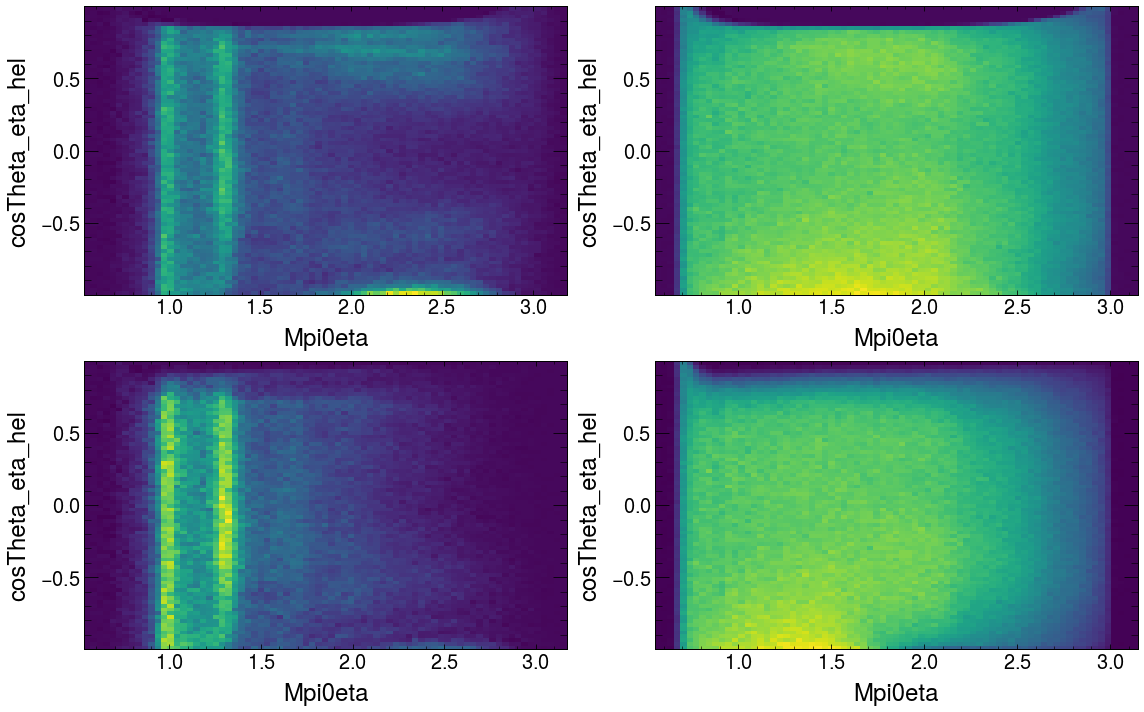

In [46]:
# Final inputs to amptools
fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

# Standard selections with Delta in
tmp = data_tmp[data_tmp.Mpi0p>1.4]
axes[0].hist2d(tmp.Mpi0eta,tmp.cosTheta_eta_hel,bins=(75,75),weights=tmp.weightASBS)
axes[0].set_xlabel("Mpi0eta")
axes[0].set_ylabel("cosTheta_eta_hel")

tmp = acc_tmp[acc_tmp.Mpi0p>1.4]
axes[1].hist2d(tmp.Mpi0eta,tmp.cosTheta_eta_hel,bins=(75,75),weights=tmp.weightASBS)
axes[1].set_xlabel("Mpi0eta")
axes[1].set_ylabel("cosTheta_eta_hel")

# What VH removes
wanted_omega=arctan(data_tmp.Mpi0eta,*popt)
wanted_omega2=arctan(data_tmp.Mpi0eta,*popt2)
data_vh_selected_2=data_tmp[(data_tmp.vanHove_omega<wanted_omega)&(data_tmp.vanHove_omega>wanted_omega2)]
axes[2].hist2d(data_vh_selected_2.Mpi0eta,data_vh_selected_2.cosTheta_eta_hel,bins=(75,75),weights=data_vh_selected_2.weightASBS)
axes[2].set_xlabel("Mpi0eta")
axes[2].set_ylabel("cosTheta_eta_hel")

wanted_omega=arctan(acc_tmp.Mpi0eta,*popt)
wanted_omega2=arctan(acc_tmp.Mpi0eta,*popt2)
acc_vh_selected_2=acc_tmp[(acc_tmp.vanHove_omega<wanted_omega)&(acc_tmp.vanHove_omega>wanted_omega2)]
axes[3].hist2d(acc_vh_selected_2.Mpi0eta,acc_vh_selected_2.cosTheta_eta_hel,bins=(75,75),weights=acc_vh_selected_2.weightASBS)
axes[3].set_xlabel("Mpi0eta")
axes[3].set_ylabel("cosTheta_eta_hel")

plt.tight_layout()

# Final Equation

$${-29.61317407*arctan(-0.9877663*M(\pi^0\eta)+2.77936736)}+330.46008765$$

$${45.26878219*arctan(-0.88242654*M(\pi^0\eta)+3.14340627)}+193.59347205$$